# Đề tài: Phân tích rủi ro và dự đoán cổ phiếu thông minh

#### Khai báo thư viện

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, expr, regexp_extract, input_file_name
from pyspark.sql.window import Window
from pyspark.sql import DataFrame

import os
import glob
from functools import reduce

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

#### Cấu hình SPARK

In [2]:
spark = SparkSession.builder \
    .appName("ReadAllStockCSVs") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.repl.eagerEval.maxNumRows", 20) \
    .getOrCreate()

#### Đọc dữ liệu 

In [3]:
base_path = "C:/Users/H13P/Desktop/BigData/stock_market_data"
folders = ["forbes2000","nasdaq", "nyse", "sp500"]

df_list = []

batch_size = 100  
for f in folders:
    csv_path = os.path.join(base_path, f, "csv", "*.csv").replace("\\", "/")
    files = glob.glob(csv_path)
    if len(files) == 0:
        print(f"Folder {csv_path} không có file CSV, bỏ qua")
        continue
    print(f"Folder {f} có {len(files)} file CSV")
    
    # đọc theo batch
    num_batches = math.ceil(len(files) / batch_size)
    for i in range(num_batches):
        batch_files = files[i*batch_size:(i+1)*batch_size]
        df_batch = spark.read.option("header", True).csv(batch_files)
        df_list.append(df_batch)

Folder forbes2000 có 1076 file CSV
Folder nasdaq có 1564 file CSV
Folder nyse có 1145 file CSV
Folder sp500 có 409 file CSV


#### Gộp các file lại và đặt tên cho symbol

In [4]:
df_raw = reduce(DataFrame.unionByName, df_list)
df_raw = df_raw.withColumn(
    "Symbol",
    regexp_extract(input_file_name(), r'([^/\\]+)\.csv$', 1)
)
# Cast các cột numeric sang double 
numeric_cols = ["Open", "High", "Low", "Close", "Adjusted Close", "Volume"]
for c in numeric_cols:
    if c in df_raw.columns:
        df_raw = df_raw.withColumn(c, col(c).cast("double"))
print("Đã gộp dữ liệu thành công")

Đã gộp dữ liệu thành công


#### Kiểm tra dữ liệu

In [5]:
df_raw.show(5, truncate=False)
df_raw.printSchema()

+----------+-------------------+-------------------+----------+-------------------+-------------------+-------------------+------+
|Date      |Low                |Open               |Volume    |High               |Close              |Adjusted Close     |Symbol|
+----------+-------------------+-------------------+----------+-------------------+-------------------+-------------------+------+
|12-12-1980|0.1283479928970337 |0.1283479928970337 |4.690336E8|0.1289059966802597 |0.1283479928970337 |0.09987381845712662|AAPL  |
|15-12-1980|0.12165199965238571|0.12221000343561172|1.758848E8|0.12221000343561172|0.12165199965238571|0.09466331452131271|AAPL  |
|16-12-1980|0.11272300034761429|0.1132809966802597 |1.05728E8 |0.1132809966802597 |0.11272300034761429|0.08771523833274841|AAPL  |
|17-12-1980|0.11551299691200256|0.11551299691200256|8.64416E7 |0.11607100069522858|0.11551299691200256|0.08988628536462784|AAPL  |
|18-12-1980|0.11886200308799744|0.11886200308799744|7.34496E7 |0.11941999942064285|

#### Lưu lại dữ liệu thô dưới dạng parquet

In [3]:
parquet_path = "C:/Users/H13P/Desktop/BigData/stock_market_data_parquet"

In [9]:
df_raw.write.mode("overwrite").partitionBy("Symbol").parquet(parquet_path)
print(f"\nĐã lưu dữ liệu thành file Parquet tại: {parquet_path}")


Đã lưu dữ liệu thành file Parquet tại: C:/Users/H13P/Desktop/BigData/stock_market_data_parquet


#### Tải dữ liệu vào df

In [4]:
df = spark.read.parquet(parquet_path)
print(f"Đã tải thành công 'df' từ file Parquet tại: {parquet_path}")

Đã tải thành công 'df' từ file Parquet tại: C:/Users/H13P/Desktop/BigData/stock_market_data_parquet


#### Thống kê mô tả dữ liệu gốc

In [5]:
df = df.cache()
original_count = df.count()
cols_to_describe = ["Symbol", "Open", "High", "Low", "Close", "Adjusted Close", "Volume"]
existing_cols = [col for col in cols_to_describe if col in df.columns]
if existing_cols:
    df.describe(existing_cols).show()
print(f"Tổng số dòng: {df.count()}")
print(f"Số lượng cổ phiếu duy nhất: {df.select('Symbol').distinct().count()}")

+-------+--------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|summary|  Symbol|                Open|                High|                Low|               Close|      Adjusted Close|              Volume|
+-------+--------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|  count|24614705|            24335473|            24335473|           24335475|            24335474|            24335474|            24335475|
|   mean|    NULL| 1.536348545401642E9|1.5669596975888755E9|1.497731583513366E9|1.5298112686802175E9|-2.77145248100566...|  2212718.8201204683|
| stddev|    NULL|2.654228256011865...|2.703538851729518...|2.58791217120204E11|2.641984704232476...|5.266591467013266E30|1.9503985415732954E7|
|    min|       A|                 0.0|                 0.0|                0.0|                 0.0|-2.55457716480817...|              

#### Xử lí dữ liệu

In [6]:
# 1. Chuyển đổi Date từ STRING sang DATE
date_format = "dd-MM-yyyy"
df_clean = df.withColumn(
    "Date_ts", 
    F.to_date(F.col("Date"), date_format)
).drop("Date").withColumnRenamed("Date_ts", "Date")

In [7]:
# 2. Drop Null
cols_to_check_null = ["Symbol", "Date", "Open", "High", "Low", "Close", "Adjusted Close", "Volume"]
df_clean = df_clean.dropna(subset=cols_to_check_null)

In [8]:
# 3. Loại dữ liệu âm / zero
df_clean = df_clean.filter(
    (F.col("Open") > 0) &
    (F.col("High") > 0) &
    (F.col("Low") > 0) &
    (F.col("Close") > 0) &
    (F.col("Adjusted Close") > 0) &
    (F.col("Volume") > 0)
)

In [9]:
# 4. Loại dữ liệu lỗi logic giá
df_clean = df_clean.filter(
    (F.col("High") >= F.col("Low")) &
    (F.col("High") >= F.col("Open")) &
    (F.col("High") >= F.col("Close")) &
    (F.col("Low") <= F.col("Open")) &
    (F.col("Low") <= F.col("Close"))
)

In [10]:
# 5. Loại symbol rác (quá ít dữ liệu)
symbol_count = df_clean.groupBy("Symbol").count()
valid_symbols = symbol_count.filter(F.col("count") > 300)
df_clean = df_clean.join(valid_symbols.select("Symbol"), "Symbol", "inner")

In [11]:
#Tạo checkpoint để không bị lỗi tràn RAM cho bước 6
checkpoint_path = "C:/Users/H13P/Desktop/BigData/spark_checkpoint_temp_clean"
print(f"Lưu checkpoint tạm thời tại: {checkpoint_path}")
df_clean.write.mode("overwrite").parquet(checkpoint_path)
df_clean.unpersist() 
df_clean = spark.read.parquet(checkpoint_path)
df_clean = df_clean.cache() 

Lưu checkpoint tạm thời tại: C:/Users/H13P/Desktop/BigData/spark_checkpoint_temp_clean


In [13]:
# 6. Loại ngoại lai theo percentile từng Symbol
price_cols = ["Open", "High", "Low", "Close", "Adjusted Close", "Volume"]
lower_pct = 0.01
upper_pct = 0.99
relative_error_target = 0.01  
accuracy = int(1 / relative_error_target) 

df_clean = df_clean.repartition(40, "Symbol")  

all_exprs = (
    [F.percentile_approx(F.col(c), lower_pct, accuracy).alias(f"{c}_p1") for c in price_cols] +
    [F.percentile_approx(F.col(c), upper_pct, accuracy).alias(f"{c}_p99") for c in price_cols]
)
percentiles = df_clean.groupBy("Symbol").agg(*all_exprs)

df_joined = df_clean.alias("data").join(percentiles.alias("bounds"), on="Symbol", how="left")

select_exprs = [F.col(f"data.{col_name}").alias(col_name) for col_name in df_clean.columns]
for c in price_cols:
    select_exprs.append(F.col(f"bounds.{c}_p1").alias(f"temp_{c}_p1"))
    select_exprs.append(F.col(f"bounds.{c}_p99").alias(f"temp_{c}_p99"))

df_with_bounds = df_joined.select(*select_exprs)

filter_conditions = []
for c in price_cols:
    filter_conditions.append(
        (F.col(c) >= F.col(f"temp_{c}_p1")) & (F.col(c) <= F.col(f"temp_{c}_p99"))
    )

if filter_conditions:
    big_filter = filter_conditions[0]
    for cond in filter_conditions[1:]:
        big_filter = big_filter & cond
    df_clean = df_with_bounds.filter(big_filter)
else:
    df_clean = df_with_bounds

# Drop temp cols
drop_cols = [f"temp_{c}_p1" for c in price_cols] + [f"temp_{c}_p99" for c in price_cols]
df_clean = df_clean.drop(*drop_cols)

In [14]:
# Checkpoint SAU BƯỚC 6 để giải phóng memory 
checkpoint_path6 = "C:/Users/H13P/Desktop/BigData/spark_checkpoint_temp_outliers"
print(f"Lưu checkpoint sau outlier removal tại: {checkpoint_path6}")
df_clean.write.mode("overwrite").parquet(checkpoint_path6)
df_clean.unpersist()
df_clean = spark.read.parquet(checkpoint_path6)
df_clean = df_clean.cache()

Lưu checkpoint sau outlier removal tại: C:/Users/H13P/Desktop/BigData/spark_checkpoint_temp_outliers


In [15]:
# 7. Lọc ngưỡng mềm cuối 
df_clean = df_clean.filter(
    (F.col("High") < 20000) &  
    (F.col("Low") > 0.1) &
    (F.col("Adjusted Close") < 20000) &
    (F.col("Volume") < 500000000)    
)

In [16]:
# 8. Loại trùng lặp Symbol + Date
df_clean = df_clean.dropDuplicates(["Symbol", "Date"])

print("Hoàn tất xử lý dữ liệu")

Hoàn tất xử lý dữ liệu


#### Kiểm tra dữ liệu sau xử lí

In [17]:
df_clean.show(5, truncate=False)
df_clean.printSchema()

+------+------------------+------------------+---------+------------------+------------------+------------------+----------+
|Symbol|Low               |Open              |Volume   |High              |Close             |Adjusted Close    |Date      |
+------+------------------+------------------+---------+------------------+------------------+------------------+----------+
|AAL   |36.349998474121094|36.599998474121094|247800.0 |37.04999923706055 |36.83000183105469 |34.72116470336914 |2005-12-22|
|AAL   |38.560001373291016|39.20000076293945 |848400.0 |39.5              |38.709999084472656|36.4935188293457  |2006-03-24|
|AAL   |28.190000534057617|28.600000381469727|1858000.0|29.489999771118164|29.040000915527344|27.377212524414062|2007-10-03|
|AAL   |14.369999885559082|15.59000015258789 |3820700.0|16.0              |14.460000038146973|13.632040977478027|2008-02-04|
|AAL   |9.579999923706055 |10.020000457763672|4335600.0|10.979999542236328|9.979999542236328 |9.40855884552002  |2008-03-11|


#### Lưu dữ liệu sau khi xử lí

In [18]:
parquet_path_clean = "C:/Users/H13P/Desktop/BigData/stock_market_data_CLEANED_parquet" 
df_clean.write.mode("overwrite").partitionBy("Symbol").parquet(parquet_path_clean)
print(f"Đã lưu thành công dữ liệu SẠCH tại: {parquet_path_clean}")

Đã lưu thành công dữ liệu SẠCH tại: C:/Users/H13P/Desktop/BigData/stock_market_data_CLEANED_parquet


#### Load dữ liệu vào df_clean

In [21]:
df_clean = spark.read.parquet(parquet_path_clean)
print(f"Đã tải thành công 'df_clean' từ file Parquet tại: {parquet_path_clean}")

Đã tải thành công 'df_clean' từ file Parquet tại: C:/Users/H13P/Desktop/BigData/stock_market_data_CLEANED_parquet


#### Thống kê mô tả dữ liệu sau xử lý

In [23]:
df_clean = df_clean.cache()
cleaned_count = df_clean.count()
rows_removed = original_count - cleaned_count 
print(f"Sau xử lý: {cleaned_count:,} dòng hợp lệ.")
print(f"Đã loại bỏ: {rows_removed:,} dòng (do null, giá phi lý hoặc trùng lặp).")
print(f"Số lượng cổ phiếu duy nhất: {df_clean.select('Symbol').distinct().count()}")
cols_to_describe = ["Symbol", "Open", "High", "Low", "Close", "Adjusted Close", "Volume"]
existing_cols = [col for col in cols_to_describe if col in df.columns]
if existing_cols:
    df_clean.describe(existing_cols).show()

Sau xử lý: 16,219,067 dòng hợp lệ.
Đã loại bỏ: 8,395,638 dòng (do null, giá phi lý hoặc trùng lặp).
Số lượng cổ phiếu duy nhất: 3204
+-------+--------+-------------------+-------------------+-------------------+-------------------+--------------------+------------------+
|summary|  Symbol|               Open|               High|                Low|              Close|      Adjusted Close|            Volume|
+-------+--------+-------------------+-------------------+-------------------+-------------------+--------------------+------------------+
|  count|16219067|           16219067|           16219067|           16219067|           16219067|            16219067|          16219067|
|   mean|    NULL|  57.29289424386848|  58.45913297628399|  56.03281750044221|  57.23273722131591|  51.211213442526216|1458901.8357593566|
| stddev|    NULL| 459.65195831709457| 471.38990596365375| 446.61417400725446|  458.5320062782198|    437.877281465843| 8722758.576322246|
|    min|       A|0.1000000014901

#### Trực quan hoá dữ liệu 

In [ ]:
# 1. Tìm 10 mã có nhiều dữ liệu nhất (trên df_clean)
top_10_symbols = df_clean.groupBy("Symbol").count() \
                             .orderBy(F.col("count").desc()) \
                             .limit(10) \
                             .select("Symbol") \
                             .rdd.flatMap(lambda x: x).collect()
print(f"--- 10 mã hàng đầu được chọn: {top_10_symbols} ---")
    
# 2. Lọc df_clean chỉ lấy 10 mã này
df_top_10 = df_clean.filter(F.col("Symbol").isin(top_10_symbols))

In [ ]:
# Sample 0.1% raw và clean 
df_raw_sample = df.sample(fraction=0.001, seed=42).toPandas()['Close'].dropna()
df_clean_sample = df_clean.sample(fraction=0.001, seed=42).toPandas()['Close'].dropna()

#### Biểu đồ phân bố giá Close của trước và sau khi clean

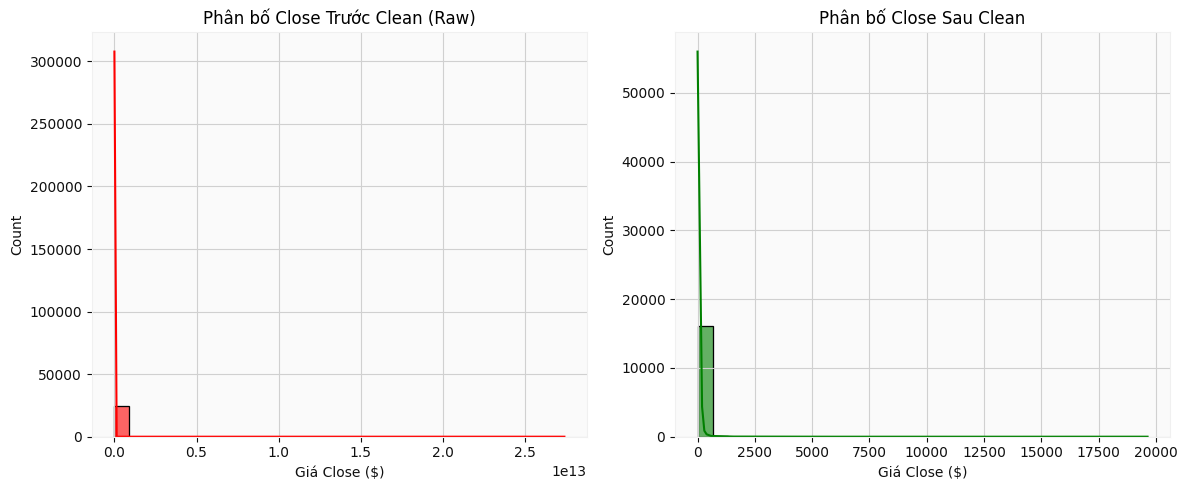

Raw sample: 24176 dòng, Mean: 1932411511.86
Clean sample: 16214 dòng, Mean: 57.82
Raw std: 215489748788.13
Clean std: 453.32


In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Trước clean (raw)
sns.histplot(df_raw_sample, bins=30, kde=True, ax=axes[0], color='red', alpha=0.6)
axes[0].set_title('Phân bố Close Trước Clean (Raw)')
axes[0].set_xlabel('Giá Close ($)')

# Sau clean
sns.histplot(df_clean_sample, bins=30, kde=True, ax=axes[1], color='green', alpha=0.6)
axes[1].set_title('Phân bố Close Sau Clean')
axes[1].set_xlabel('Giá Close ($)')

plt.tight_layout()
plt.show()

print(f"Raw sample: {len(df_raw_sample)} dòng, Mean: {df_raw_sample.mean():.2f}")
print(f"Clean sample: {len(df_clean_sample)} dòng, Mean: {df_clean_sample.mean():.2f}")
print(f"Raw std: {df_raw_sample.std():.2f}")  # Cao, rủi ro lớn
print(f"Clean std: {df_clean_sample.std():.2f}")  # Thấp hơn, rủi ro giảm

#### Biểu đồ Boxplot và Scatter để phân tích ngoại lai trước và sau khi clean

C:\Users\H13P\AppData\Local\Temp\ipykernel_19600\177281036.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_compare, x='Loại', y='Giá Close', palette={'Raw': 'red', 'Clean': 'green'})


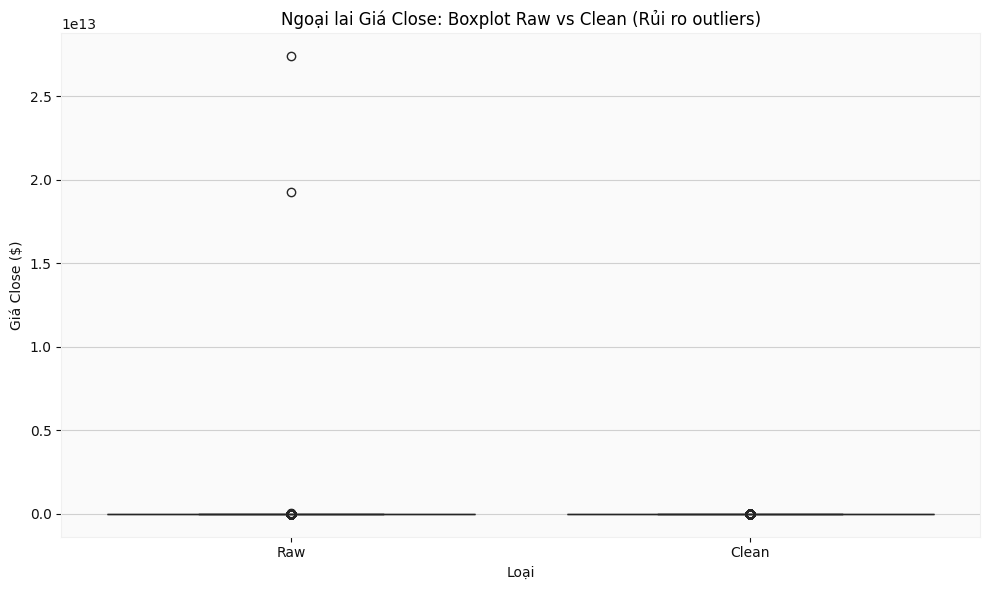

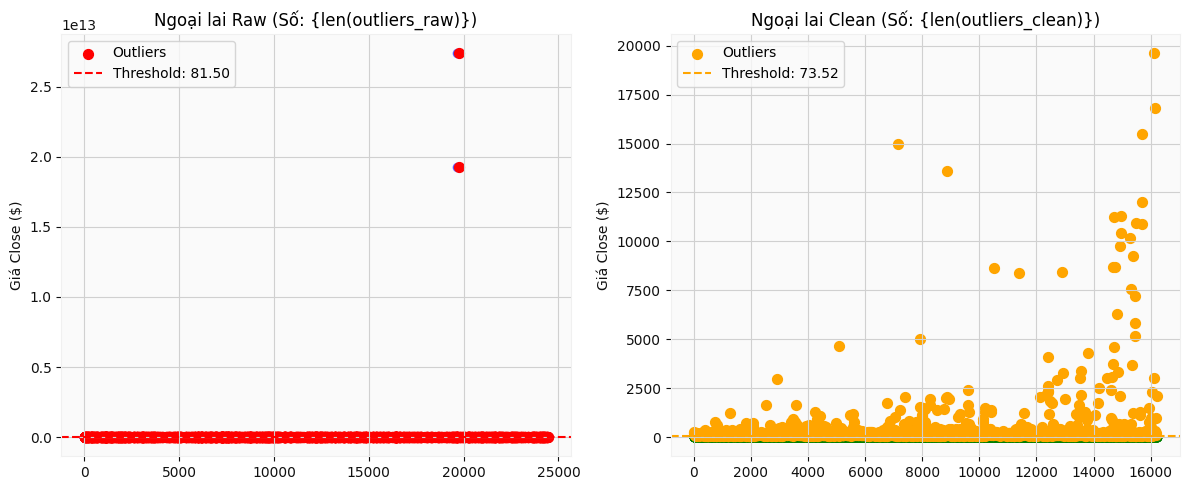

Raw: 2312 outliers (9.6%)
Clean: 1551 outliers (9.6%)


In [65]:
df_raw_sample = df.sample(fraction=0.001, seed=42).select("Close").toPandas()["Close"].dropna()
df_clean_sample = df_clean.sample(fraction=0.001, seed=42).select("Close").toPandas()["Close"].dropna()

df_raw_sample = df_raw_sample[df_raw_sample > 0]
df_clean_sample = df_clean_sample[df_clean_sample > 0]

# DataFrame so sánh
data_compare = pd.DataFrame({
    'Giá Close': pd.concat([df_raw_sample, df_clean_sample]),
    'Loại': ['Raw'] * len(df_raw_sample) + ['Clean'] * len(df_clean_sample)
})

# 1. Boxplot (outliers rõ ràng)
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_compare, x='Loại', y='Giá Close', palette={'Raw': 'red', 'Clean': 'green'})
plt.title('Ngoại lai Giá Close: Boxplot Raw vs Clean (Rủi ro outliers)')
plt.ylabel('Giá Close ($)')
plt.tight_layout()
plt.show()

# 2. Scatter với threshold (IQR method)
q1_raw = df_raw_sample.quantile(0.25)
q3_raw = df_raw_sample.quantile(0.75)
iqr_raw = q3_raw - q1_raw
threshold_raw = q3_raw + 1.5 * iqr_raw

q1_clean = df_clean_sample.quantile(0.25)
q3_clean = df_clean_sample.quantile(0.75)
iqr_clean = q3_clean - q1_clean
threshold_clean = q3_clean + 1.5 * iqr_clean

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw scatter (outliers đỏ)
outliers_raw = df_raw_sample[df_raw_sample > threshold_raw]
axes[0].scatter(range(len(df_raw_sample)), df_raw_sample, alpha=0.5, color='blue')
axes[0].scatter(df_raw_sample[df_raw_sample > threshold_raw].index, outliers_raw, color='red', s=50, label='Outliers')
axes[0].axhline(threshold_raw, color='red', linestyle='--', label=f'Threshold: {threshold_raw:.2f}')
axes[0].set_title('Ngoại lai Raw (Số: {len(outliers_raw)})')
axes[0].set_ylabel('Giá Close ($)')
axes[0].legend()

# Clean scatter (ít outliers)
outliers_clean = df_clean_sample[df_clean_sample > threshold_clean]
axes[1].scatter(range(len(df_clean_sample)), df_clean_sample, alpha=0.5, color='green')
axes[1].scatter(df_clean_sample[df_clean_sample > threshold_clean].index, outliers_clean, color='orange', s=50, label='Outliers')
axes[1].axhline(threshold_clean, color='orange', linestyle='--', label=f'Threshold: {threshold_clean:.2f}')
axes[1].set_title('Ngoại lai Clean (Số: {len(outliers_clean)})')
axes[1].set_ylabel('Giá Close ($)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Raw: {len(outliers_raw)} outliers ({len(outliers_raw)/len(df_raw_sample)*100:.1f}%)")
print(f"Clean: {len(outliers_clean)} outliers ({len(outliers_clean)/len(df_clean_sample)*100:.1f}%)")

#### Biểu đồ phân bố top 10 cổ phiếu

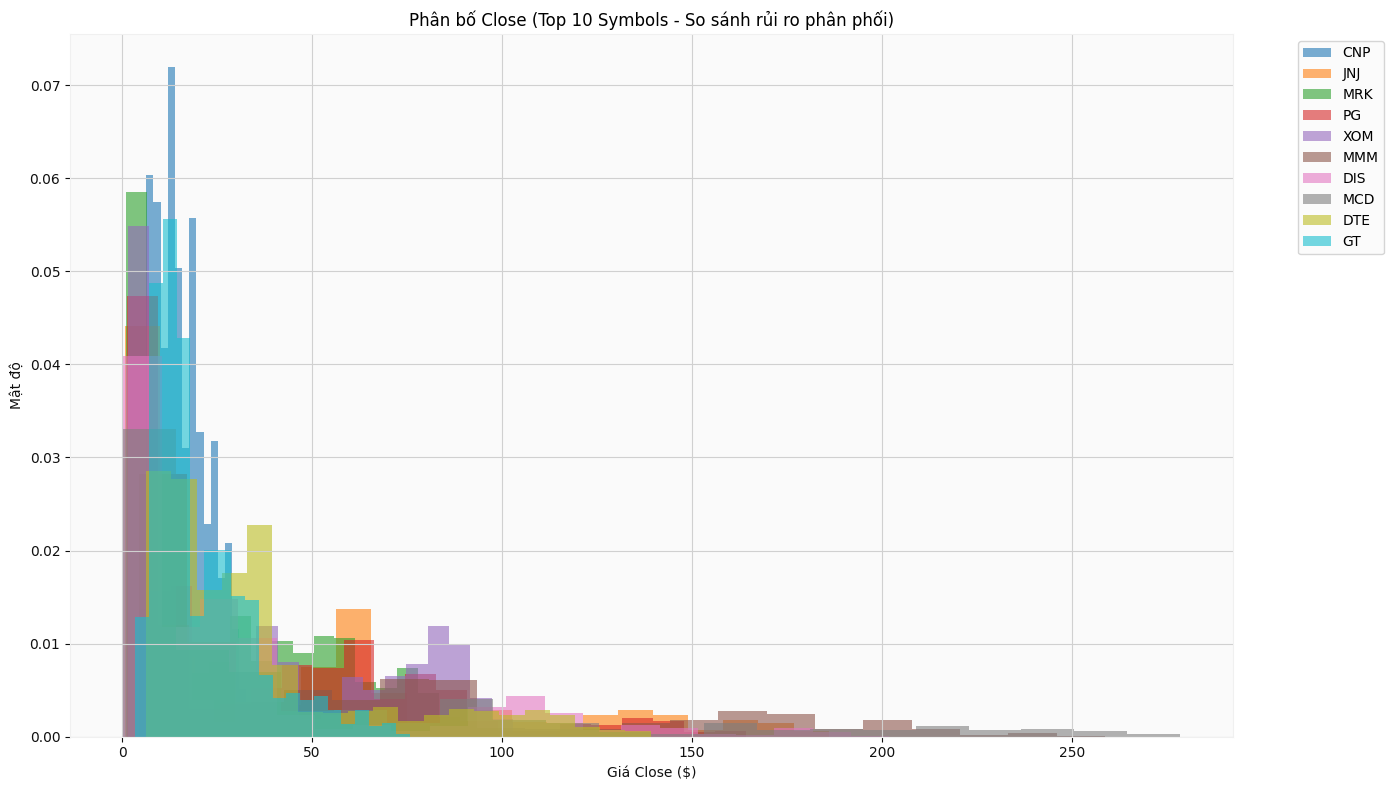

In [51]:
df_top_pd = df_clean.filter(F.col("Symbol").isin(top_10_symbols)).toPandas()
df_top_pd['Date'] = pd.to_datetime(df_top_pd['Date'])

plt.figure(figsize=(14, 8))
for i, sym in enumerate(top_10_symbols):
    sym_data = df_top_pd[df_top_pd['Symbol'] == sym]['Close']
    plt.hist(sym_data, bins=20, alpha=0.6, label=sym, density=True)  # Density để so sánh phân bố
plt.title('Phân bố Close (Top 10 Symbols - So sánh rủi ro phân phối)')
plt.xlabel('Giá Close ($)')
plt.ylabel('Mật độ')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Biểu đồ phân phối Volume của 5 cổ phiếu

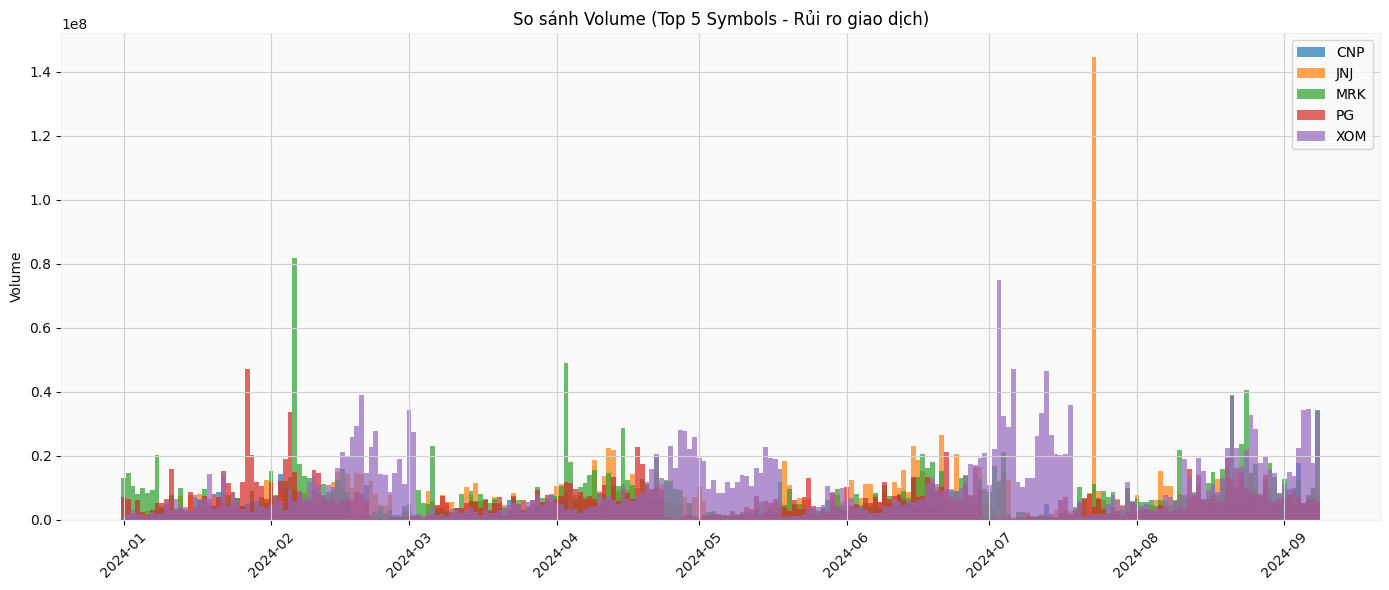

In [52]:
df_top_pd = df_clean.filter(F.col("Symbol").isin(top_10_symbols)).toPandas()

fig, ax = plt.subplots(figsize=(14, 6))
for sym in top_10_symbols[:5]:  # Giới hạn 5 để không rối
    sym_vol = df_top_pd[df_top_pd['Symbol'] == sym]['Volume'].tail(252)  # 1 năm gần nhất
    sym_dates = pd.date_range(start='2024-01-01', periods=len(sym_vol), freq='D')[:len(sym_vol)]
    ax.bar(sym_dates, sym_vol, alpha=0.7, label=sym, width=1)
ax.set_title('So sánh Volume (Top 5 Symbols - Rủi ro giao dịch)')
ax.set_ylabel('Volume')
ax.legend()
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

#### Biểu đồ nến cho từng mã cụ thể

Tổng dòng raw cho AAPL: 31770


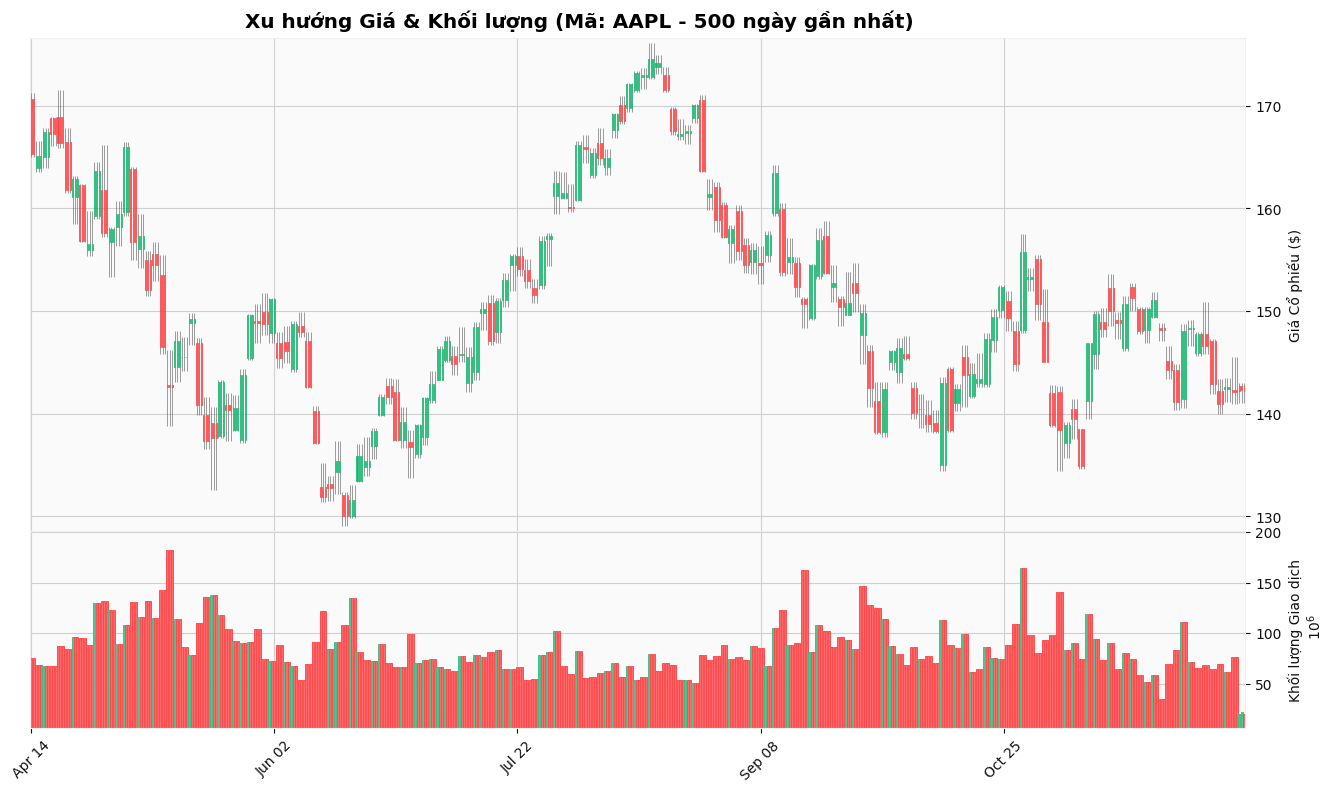

Đã lưu PNG tại: candlestick_AAPL_recent_500days.png


In [33]:
symbol_to_plot = "AAPL"

try:
    # Filter và chuyển sang Pandas 
    df_one_symbol_pd = df.filter(F.col("Symbol") == symbol_to_plot) \
                         .select("Date", "Open", "High", "Low", "Close", "Volume") \
                         .toPandas()
    if not df_one_symbol_pd.empty:
        print(f"Tổng dòng raw cho {symbol_to_plot}: {len(df_one_symbol_pd)}")
        
        # Chuyển đổi Date 
        df_one_symbol_pd['Date'] = pd.to_datetime(df_one_symbol_pd['Date'], dayfirst=True)
       
        # Đặt Date làm index
        df_one_symbol_pd = df_one_symbol_pd.set_index('Date')
        # Sắp xếp (sort) bằng Pandas SAU KHI đã chuyển đổi ngày
        df_one_symbol_pd = df_one_symbol_pd.sort_index(ascending=True)
       
        # Lấy đúng 500 ngày cuối 
        df_to_plot = df_one_symbol_pd.tail(500)  
        # Tùy chọn: Nếu muốn nhiều năm, thay bằng
        # df_to_plot = df_one_symbol_pd[df_one_symbol_pd.index.year >= 2020]
        plot_title = f"Xu hướng Giá & Khối lượng (Mã: {symbol_to_plot} - 500 ngày gần nhất)"
        
        fig, axes = mpf.plot(
            df_to_plot,
            type='candle',
            style='yahoo',
            title=plot_title,
            ylabel='Giá Cổ phiếu ($)',
            volume=True,
            ylabel_lower='Khối lượng Giao dịch',
            figsize=(14, 8),
            returnfig=True,  
            tight_layout=True,
            show_nontrading=False
        )

        if fig._suptitle:  # Nếu có title
            fig._suptitle.set_y(0.98)
            
        plt.show(block=False)  
        
        # Lưu PNG 
        plot_filename = f'candlestick_{symbol_to_plot}_recent_500days.png'
        fig.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"Đã lưu PNG tại: {plot_filename}")
       
    else:
        print(f"Không tìm thấy dữ liệu cho mã '{symbol_to_plot}' trong dữ liệu thô.")

except Exception as e:
    print(f"Lỗi khi vẽ biểu đồ nến: {e}")
    traceback.print_exc()

#### Biểu đồ đường 

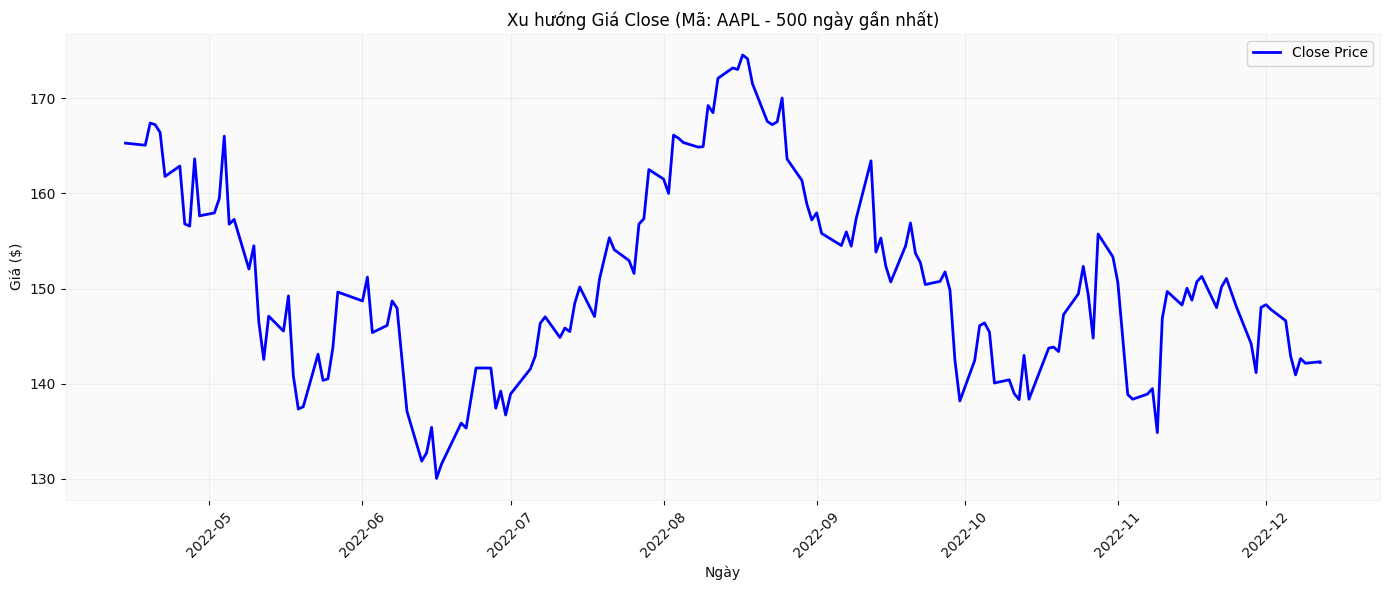

In [34]:
plt.figure(figsize=(14, 6))
plt.plot(df_to_plot.index, df_to_plot['Close'], linewidth=2, color='blue', label='Close Price')
plt.title('Xu hướng Giá Close (Mã: AAPL - 500 ngày gần nhất)')
plt.ylabel('Giá ($)')
plt.xlabel('Ngày')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Heatmap tương quan giữa 10 mã cổ phiếu

--- 10 mã hàng đầu được chọn: ['CNP', 'JNJ', 'MRK', 'PG', 'XOM', 'MMM', 'DIS', 'MCD', 'DTE', 'GT'] ---
Số row sau dropna: 13355


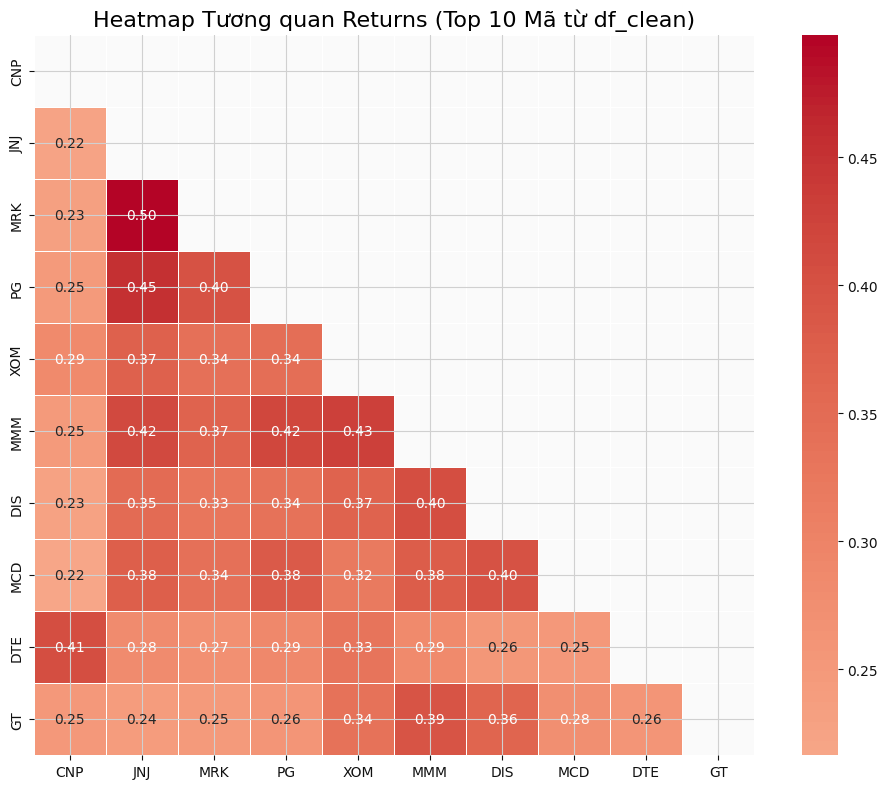

In [50]:
try:    
    # 3. Pivot trong Spark
    df_pivot = df_top_10.groupBy("Date") \
                        .pivot("Symbol", top_10_symbols) \
                        .agg(F.first("Close")) \
                        .orderBy("Date")
    
    # 4. Chuyển sang Pandas
    pivot_pd = df_pivot.toPandas().set_index("Date")
    
    # 5. Xử lý quan trọng cho Heatmap (SỬA: pivot_pd thay pivot_pd_raw)
    pivot_pd = pivot_pd.replace(0, np.nan).dropna(how='any')
    
    # CẢI THIỆN: Tính returns (pct_change) cho corr chính xác hơn
    returns_pd = pivot_pd.pct_change().dropna(how='any')
    
    print(f"Số row sau dropna: {len(returns_pd)}")  # Check data
    
    if len(returns_pd) < 10:
        print("Data sau dropna quá ít – thử sample hoặc top by mean Close.")
    else:
        # 6. Tính ma trận tương quan 
        corr_matrix = returns_pd.corr()
        
        # 7. Vẽ Heatmap 
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Che nửa trên
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                    square=True, fmt='.2f', linewidths=0.5, mask=mask)
        plt.title("Heatmap Tương quan Returns (Top 10 Mã từ df_clean)", fontsize=16)
        plt.tight_layout()
        plt.show()  
        
except Exception as e:
    print(f"Lỗi khi tạo heatmap (thường do OOM hoặc dữ liệu quá bẩn): {e}")
    import traceback
    traceback.print_exc()

#### Tính LOG RETURN

In [66]:
w = Window.partitionBy("Symbol").orderBy("Date") 

df_ret = df_clean.withColumn("prev_adj_close", F.lag("Adjusted Close").over(w))
df_ret = df_ret.withColumn(
    "log_return", 
    F.when(F.col("prev_adj_close").isNotNull(), 
           F.log(F.col("Adjusted Close") / F.col("prev_adj_close")))
)
df_ret = df_ret.dropna(subset=["log_return"])
print(f"Đã tính log_return, còn {df_ret.count():,} dòng.")

Đã tính log_return, còn 16,215,863 dòng.


#### CÁC KỸ THUẬT ĐẶC TRƯNG MỞ RỘNG

In [67]:
# Định nghĩa các cửa sổ (Windows)
w_roll_7d = w.rowsBetween(-6, Window.currentRow)
w_roll_30d = w.rowsBetween(-29, Window.currentRow)

In [68]:
# === TÍNH MACD (12, 26, 9) ===
w_macd_12 = w.rowsBetween(-11, Window.currentRow) # 12-day SMA
w_macd_26 = w.rowsBetween(-25, Window.currentRow) # 26-day SMA

df_features = df_ret.withColumn(
    "SMA_12", F.avg("Adjusted Close").over(w_macd_12)
).withColumn(
    "SMA_26", F.avg("Adjusted Close").over(w_macd_26)
)
df_features = df_features.withColumn(
    "MACD", F.col("SMA_12") - F.col("SMA_26")
)
w_macd_signal = w.rowsBetween(-8, Window.currentRow) 
df_features = df_features.withColumn(
    "MACD_Signal", F.avg("MACD").over(w_macd_signal)
)
df_features = df_features.withColumn(
    "MACD_Hist", F.col("MACD") - F.col("MACD_Signal")
)
print("Đã tính xong MACD")

Đã tính xong MACD


In [69]:
# === TÍNH RSI (14-ngày) ===
df_features = df_features.withColumn(
    "change", F.col("Adjusted Close") - F.col("prev_adj_close")
)
df_features = df_features.withColumn(
    "Gain", F.when(F.col("change") > 0, F.col("change")).otherwise(0)
).withColumn(
    "Loss", F.when(F.col("change") < 0, -F.col("change")).otherwise(0)
)
w_rsi_14 = w.rowsBetween(-13, Window.currentRow) 
df_features = df_features.withColumn(
    "Avg_Gain_14", F.avg("Gain").over(w_rsi_14)
).withColumn(
    "Avg_Loss_14", F.avg("Loss").over(w_rsi_14)
)
df_features = df_features.withColumn(
    "RS", 
    F.when(F.col("Avg_Loss_14") != 0, F.col("Avg_Gain_14") / F.col("Avg_Loss_14"))
     .otherwise(None)
)
df_features = df_features.withColumn(
    "RSI_14", 100.0 - (100.0 / (1.0 + F.col("RS")))
)
print("Đã tính xong RSI")

Đã tính xong RSI


In [70]:
#Tính các đặc trưng còn lại (log_return, SMA_7, Rolling_Std_30)
df_features = df_features.withColumn(
    "log_return_lag_1", F.lag("log_return", 1).over(w)
).withColumn(
    "SMA_7", F.avg("Adjusted Close").over(w_roll_7d)
).withColumn(
    "Rolling_Std_30", F.stddev("log_return").over(w_roll_30d)
)

features_cols_raw = [
    "log_return", 
    "log_return_lag_1", 
    "SMA_7", 
    "Rolling_Std_30",
    "RSI_14",               
    "MACD",                
    "MACD_Signal",         
    "MACD_Hist"            
]

df_features = df_features.dropna(subset=features_cols_raw)

print(f"Đã tạo đặc trưng mở rộng, còn {df_features.count():,} dòng hợp lệ.")
print(f"Các đặc trưng thô bao gồm: {features_cols_raw}")

Đã tạo đặc trưng mở rộng, còn 16,195,302 dòng hợp lệ.
Các đặc trưng thô bao gồm: ['log_return', 'log_return_lag_1', 'SMA_7', 'Rolling_Std_30', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist']


In [89]:
symbol = "JNJ"   # thay bằng Symbol bạn muốn
df_plot = df_features.filter(F.col("Symbol") == symbol).orderBy("Date")
pdf = df_plot.toPandas()   # chuyển sang pandas

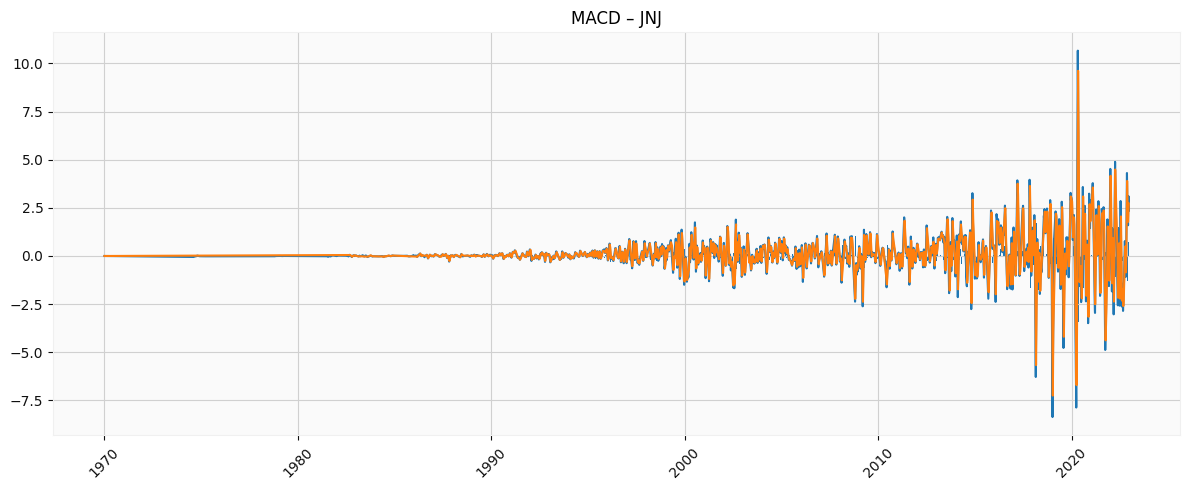

In [90]:
#Vẽ MACD
plt.figure(figsize=(12,5))
plt.plot(pdf["Date"], pdf["MACD"])
plt.plot(pdf["Date"], pdf["MACD_Signal"])
plt.bar(pdf["Date"], pdf["MACD_Hist"])
plt.title(f"MACD – {symbol}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

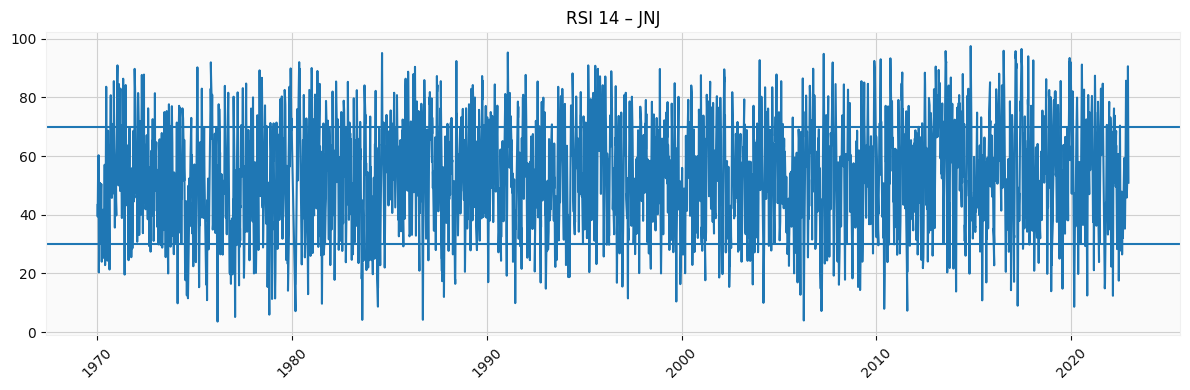

In [91]:
#Vẽ RSI
plt.figure(figsize=(12,4))
plt.plot(pdf["Date"], pdf["RSI_14"])
plt.axhline(70)   # Overbought
plt.axhline(30)   # Oversold
plt.title(f"RSI 14 – {symbol}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

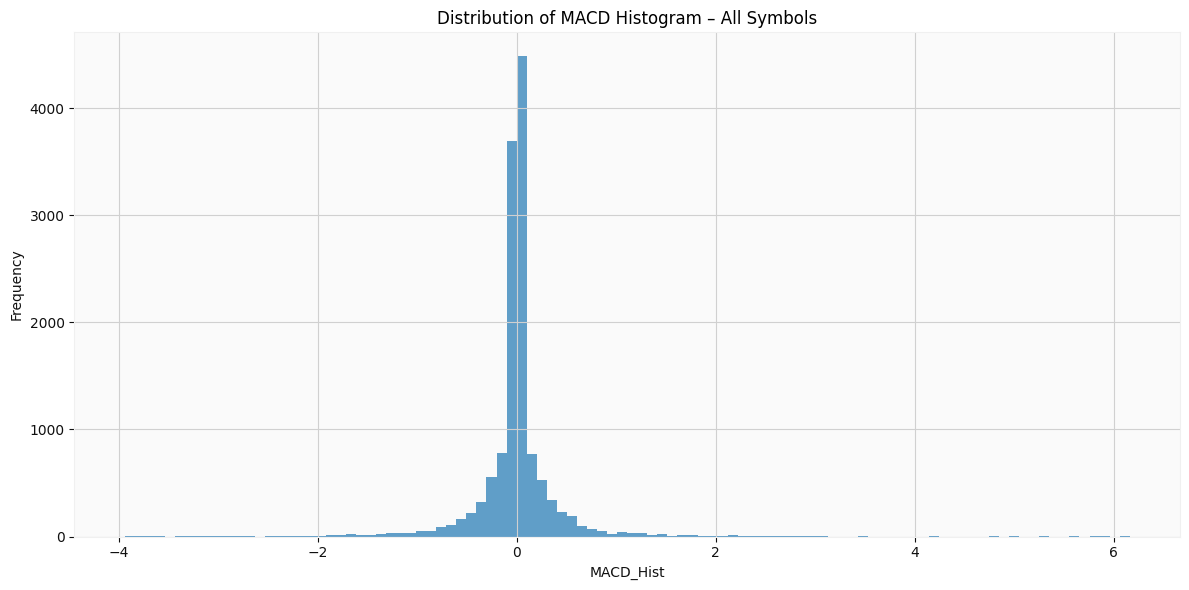

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.hist(pdf["MACD_Hist"].dropna(), bins=100, alpha=0.7)

plt.title("Distribution of MACD Histogram – All Symbols")
plt.xlabel("MACD_Hist")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


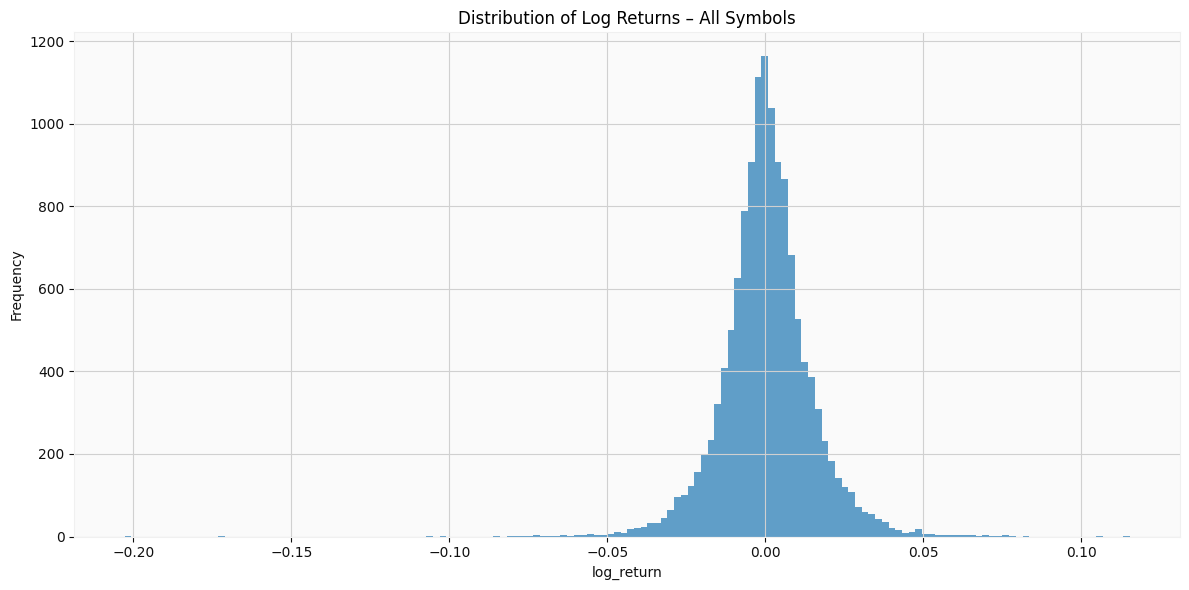

In [98]:
plt.figure(figsize=(12,6))
plt.hist(pdf["log_return"].dropna(), bins=150, alpha=0.7)
plt.title("Distribution of Log Returns – All Symbols")
plt.xlabel("log_return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#### Chuẩn hoá Z-score

In [99]:
stats_agg = []
for col_name in features_cols_raw:
    stats_agg.append(F.mean(col_name).alias(f"{col_name}_mean"))
    stats_agg.append(F.stddev(col_name).alias(f"{col_name}_std"))

# Tính bảng thống kê (Mean/Std) trên dữ liệu huấn luyện
stats = df_features.groupBy("Symbol").agg(*stats_agg)

# LƯU BẢNG THỐNG KÊ (MEAN/STD) CHO TRIỂN KHAI
PATH_STATS_OUTPUT = "models/stats_lookup_table" 
stats.write.mode("overwrite").parquet(PATH_STATS_OUTPUT)
print(f"Đã lưu bảng thống kê Mean/Std tại: {PATH_STATS_OUTPUT}")

# Tiếp tục bước chuẩn hóa
df_scaled = df_features.join(stats, on="Symbol", how="left")

features_cols_scaled = []
for col_name in features_cols_raw:
    scaled_col_name = f"{col_name}_scaled"
    features_cols_scaled.append(scaled_col_name)
    
    mean_col = f"{col_name}_mean"
    std_col = f"{col_name}_std"
    
    df_scaled = df_scaled.withColumn(
        scaled_col_name,
        F.when(
            (F.col(std_col).isNotNull()) & (F.col(std_col) != 0),
            (F.col(col_name) - F.col(mean_col)) / F.col(std_col)
        ).otherwise(0.0) 
    )
print(f"Đã chuẩn hoá Z-score cho {len(features_cols_raw)} đặc trưng.")

Đã lưu bảng thống kê Mean/Std tại: models/stats_lookup_table
Đã chuẩn hoá Z-score cho 8 đặc trưng.


#### Thống kê kiểm tra 

In [100]:
print("Thống kê trung bình & độ lệch chuẩn sau chuẩn hoá (10 mã đầu):")
check_agg = []
for col_name in features_cols_scaled:
    check_agg.append(F.mean(col_name).alias(f"{col_name}_mean"))
    check_agg.append(F.stddev(col_name).alias(f"{col_name}_std"))

df_symbol_stats = df_scaled.groupBy("Symbol").agg(*check_agg)

cols_to_show_simple = [
    "Symbol", 
    "log_return_scaled_mean", 
    "log_return_scaled_std",
    "RSI_14_scaled_mean", 
    "RSI_14_scaled_std",
    "Rolling_Std_30_scaled_mean",
    "Rolling_Std_30_scaled_std"
]

print("--- Bảng tóm tắt thống kê chuẩn hoá ---")
existing_cols_to_show = [col for col in cols_to_show_simple if col in df_symbol_stats.columns]
df_symbol_stats.select(existing_cols_to_show).orderBy("Symbol").show(10, truncate=20)

Thống kê trung bình & độ lệch chuẩn sau chuẩn hoá (10 mã đầu):
--- Bảng tóm tắt thống kê chuẩn hoá ---
+------+----------------------+---------------------+--------------------+------------------+--------------------------+-------------------------+
|Symbol|log_return_scaled_mean|log_return_scaled_std|  RSI_14_scaled_mean| RSI_14_scaled_std|Rolling_Std_30_scaled_mean|Rolling_Std_30_scaled_std|
+------+----------------------+---------------------+--------------------+------------------+--------------------------+-------------------------+
|     A|  -3.06162847190667...|   1.0000000000000024|1.082687503555945...|1.0000000000000024|      -7.41378118266687...|       1.0000000000000047|
|   AAC|  4.453260034394165...|   1.0000000000000007|-6.76413657595697...|1.0000000000000004|      -1.08066847651592...|       1.0000000000000007|
| AACAY|  -8.26295830737876...|   1.0000000000000007|-4.30131779070610...|0.9999999999999998|      4.590620885178911...|       0.9999999999999996|
|   AAL|  -3.60

#### LƯU KẾT QUẢ CHUẨN HOÁ

In [101]:
output_path = "C:/Users/H13P/Desktop/BigData/stock_market_log_scaled"

cols_to_save = ["Symbol", "Date", "Adjusted Close", "Volume"] + features_cols_raw + features_cols_scaled
df_final_output = df_scaled.select(cols_to_save)
print(f"Bắt đầu lưu {len(cols_to_save)} cột dữ liệu đã chuẩn hoá...")
df_final_output.write.mode("overwrite").partitionBy("Symbol").parquet(output_path)
print(f"Lưu {len(cols_to_save)} cột dữ liệu đã chuẩn hoá (có RSI, MACD) xong tại: {output_path}")

# Giải phóng cache của df_scaled
df_scaled.unpersist()

Bắt đầu lưu 20 cột dữ liệu đã chuẩn hoá...
Lưu 20 cột dữ liệu đã chuẩn hoá (có RSI, MACD) xong tại: C:/Users/H13P/Desktop/BigData/stock_market_log_scaled


Symbol,Low,Open,Volume,High,Close,Adjusted Close,Date,prev_adj_close,log_return,SMA_12,SMA_26,MACD,MACD_Signal,MACD_Hist,change,Gain,Loss,Avg_Gain_14,Avg_Loss_14,RS,RSI_14,log_return_lag_1,SMA_7,Rolling_Std_30,log_return_mean,log_return_std,log_return_lag_1_mean,log_return_lag_1_std,SMA_7_mean,SMA_7_std,Rolling_Std_30_mean,Rolling_Std_30_std,RSI_14_mean,RSI_14_std,MACD_mean,MACD_std,MACD_Signal_mean,MACD_Signal_std,MACD_Hist_mean,MACD_Hist_std,log_return_scaled,log_return_lag_1_scaled,SMA_7_scaled,Rolling_Std_30_scaled,RSI_14_scaled,MACD_scaled,MACD_Signal_scaled,MACD_Hist_scaled
AAT,20.8799991607666,21.420000076293945,1010200.0,21.420000076293945,21.25,14.82027816772461,2011-01-19,14.903972625732422,-0.00563140714772...,14.86212412516276,14.86212412516276,0.0,0.0,0.0,-0.0836944580078125,0.0,0.0836944580078125,0.027898152669270832,0.027898152669270832,1.0,50.0,0.002811996158214...,14.86212412516276,0.00487694305815428,2.003731220303414...,0.017963484540915557,2.010660539180039...,0.017963545262299468,29.098246366667027,7.4934295214255675,0.015027600728555671,0.009833506661572122,52.2463824591579,15.493984562202533,0.03041256284710425,0.7896365520964735,0.030374552306089,0.749386406382856,3.801054101524962E-5,0.37258840808114646,-0.3246463823022665,0.14534603644060015,-1.8998139904832192,-1.0322520764712193,-0.14498416789687102,-0.03851463406342999,-0.04053256377134077,-1.02017508303616...
AAT,21.030000686645508,21.049999237060547,736600.0,21.399999618530273,21.209999084472656,14.792380332946777,2011-01-20,14.82027816772461,-0.00188418361901...,14.844688177108765,14.844688177108765,0.0,0.0,0.0,-0.02789783477783203,0.0,0.02789783477783203,0.020923614501953125,0.027898073196411133,0.7500021365147462,42.8572126208045,-0.00563140714772...,14.844688177108765,0.004091933451625411,2.003731220303414...,0.017963484540915557,2.010660539180039...,0.017963545262299468,29.098246366667027,7.4934295214255675,0.015027600728555671,0.009833506661572122,52.2463824591579,15.493984562202533,0.03041256284710425,0.7896365520964735,0.030374552306089,0.749386406382856,3.801054101524962E-5,0.37258840808114646,-0.11604411918530654,-0.3246838592535151,-1.9021408220099776,-1.1120821547480326,-0.6059880723812138,-0.03851463406342999,-0.04053256377134077,-1.02017508303616...
AAT,21.030000686645508,21.299999237060547,636800.0,21.299999237060547,21.25,14.82027816772461,2011-01-21,14.792380332946777,0.001884183619018962,14.839806175231933,14.839806175231933,0.0,0.0,0.0,0.02789783477783203,0.02789783477783203,0.0,0.022318458557128905,0.022318458557128905,1.0,50.0,-0.00188418361901...,14.839806175231933,0.003696939376204...,2.003731220303414...,0.017963484540915557,2.010660539180039...,0.017963545262299468,29.098246366667027,7.4934295214255675,0.015027600728555671,0.009833506661572122,52.2463824591579,15.493984562202533,0.03041256284710425,0.7896365520964735,0.030374552306089,0.749386406382856,3.801054101524962E-5,0.37258840808114646,0.09373518223334638,-0.11608230126563285,-1.902792326352932,-1.1522503357454328,-0.14498416789687102,-0.03851463406342999,-0.04053256377134077,-1.02017508303616...
AAT,21.100000381469727,21.200000762939453,354300.0,21.389999389648438,21.299999237060547,14.855144500732422,2011-01-24,14.82027816772461,0.002349846837299...,14.842362562815348,14.842362562815348,0.0,0.0,0.0,0.0348663330078125,0.0348663330078125,0.0,0.024409770965576172,0.01859871546427409,1.3124439164879116,56.7557079819355,0.001884183619018962,14.842362562815348,0.003442990748490...,2.003731220303414...,0.017963484540915557,2.010660539180039...,0.017963545262299468,29.098246366667027,7.4934295214255675,0.015027600728555671,0.009833506661572122,52.2463824591579,15.493984562202533,0.03041256284710425,0.7896365520964735,0.030374552306089,0.749386406382856,3.801054101524962E-5,0.37258840808114646,0.11965794890033761,0.09369629104525141,-1.9024511758054952,-1.1780751647157683,0.29103717669746937,-0.03851463406342999,-0.04053256377134077,-1.02017508303616...
AAT,21.14999961853

#### Kiểm tra phân phối

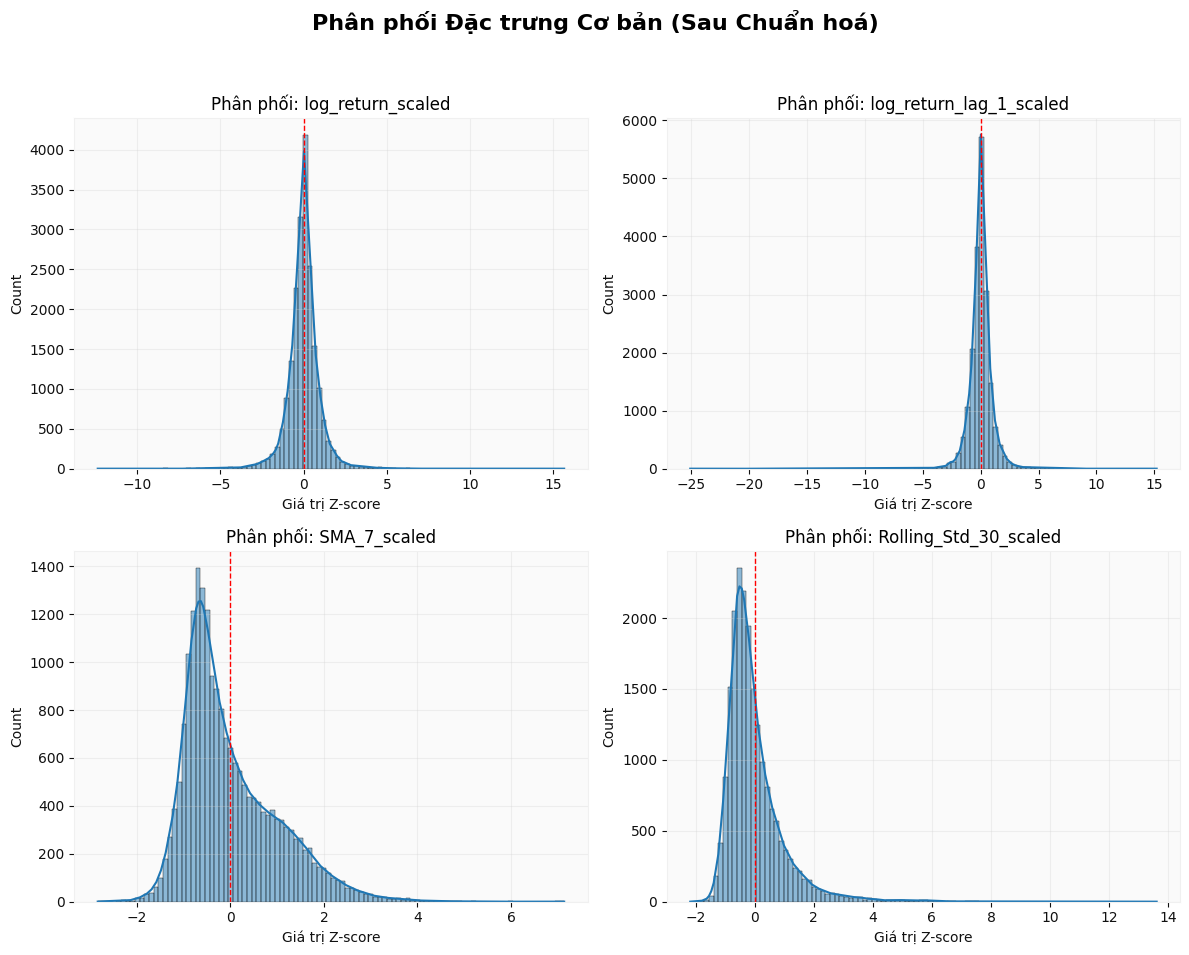

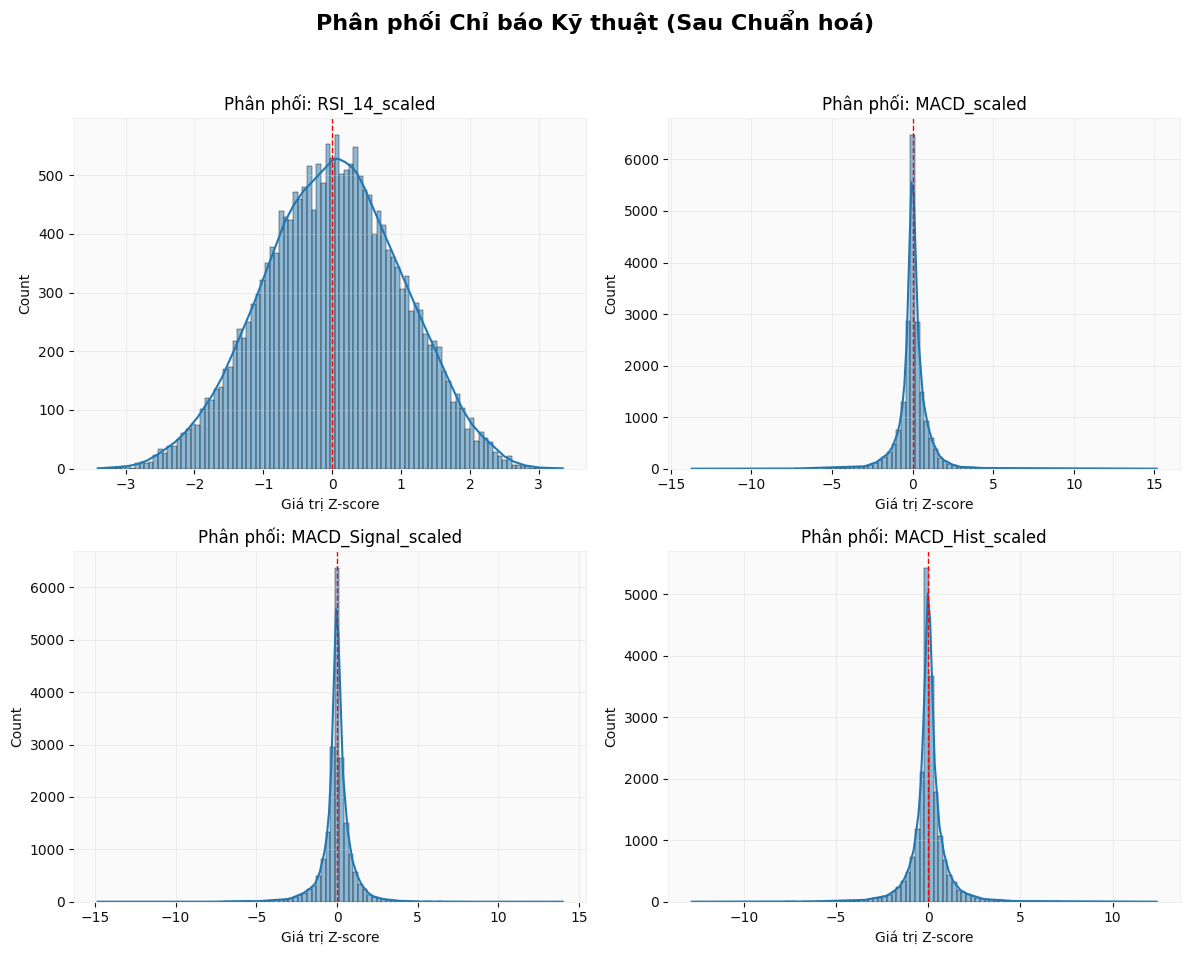

In [103]:
total_rows = df_scaled.count()
sample_size = min(20000, total_rows) 
fraction = sample_size / total_rows if total_rows > 0 else 0

if fraction > 0:
    cols_for_sampling = ["Symbol"] + features_cols_scaled 
    sample_pd = df_scaled.select(cols_for_sampling).sample(False, fraction, seed=42).toPandas()
  
    # Hàm trợ giúp vẽ 
    def plot_hist(ax, data, title):
        sns.histplot(data, bins=100, kde=True, ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Giá trị Z-score")
        ax.axvline(0, color='red', linestyle='--', linewidth=1) # Đường mean=0
        ax.grid(True, alpha=0.3)
        
    if not sample_pd.empty:
        fig1, axes1 = plt.subplots(2, 2, figsize=(12, 10)) 
        fig1.suptitle("Phân phối Đặc trưng Cơ bản (Sau Chuẩn hoá)", fontsize=16)
        axes_flat_1 = axes1.flatten()
        basic_features = features_cols_scaled[:4] 
        for i, col_name in enumerate(basic_features):
            plot_hist(axes_flat_1[i], sample_pd[col_name], f"Phân phối: {col_name}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


        fig2, axes2 = plt.subplots(2, 2, figsize=(12, 10))
        fig2.suptitle("Phân phối Chỉ báo Kỹ thuật (Sau Chuẩn hoá)", fontsize=16)
        axes_flat_2 = axes2.flatten()
        technical_features = features_cols_scaled[4:] 
        for i, col_name in enumerate(technical_features):
            plot_hist(axes_flat_2[i], sample_pd[col_name], f"Phân phối: {col_name}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("Không lấy được mẫu dữ liệu để vẽ biểu đồ.")
else:
    print("DataFrame rỗng, không thể lấy mẫu.")

#### BIỂU ĐỒ SO SÁNH (HEATMAP & BOXPLOT)

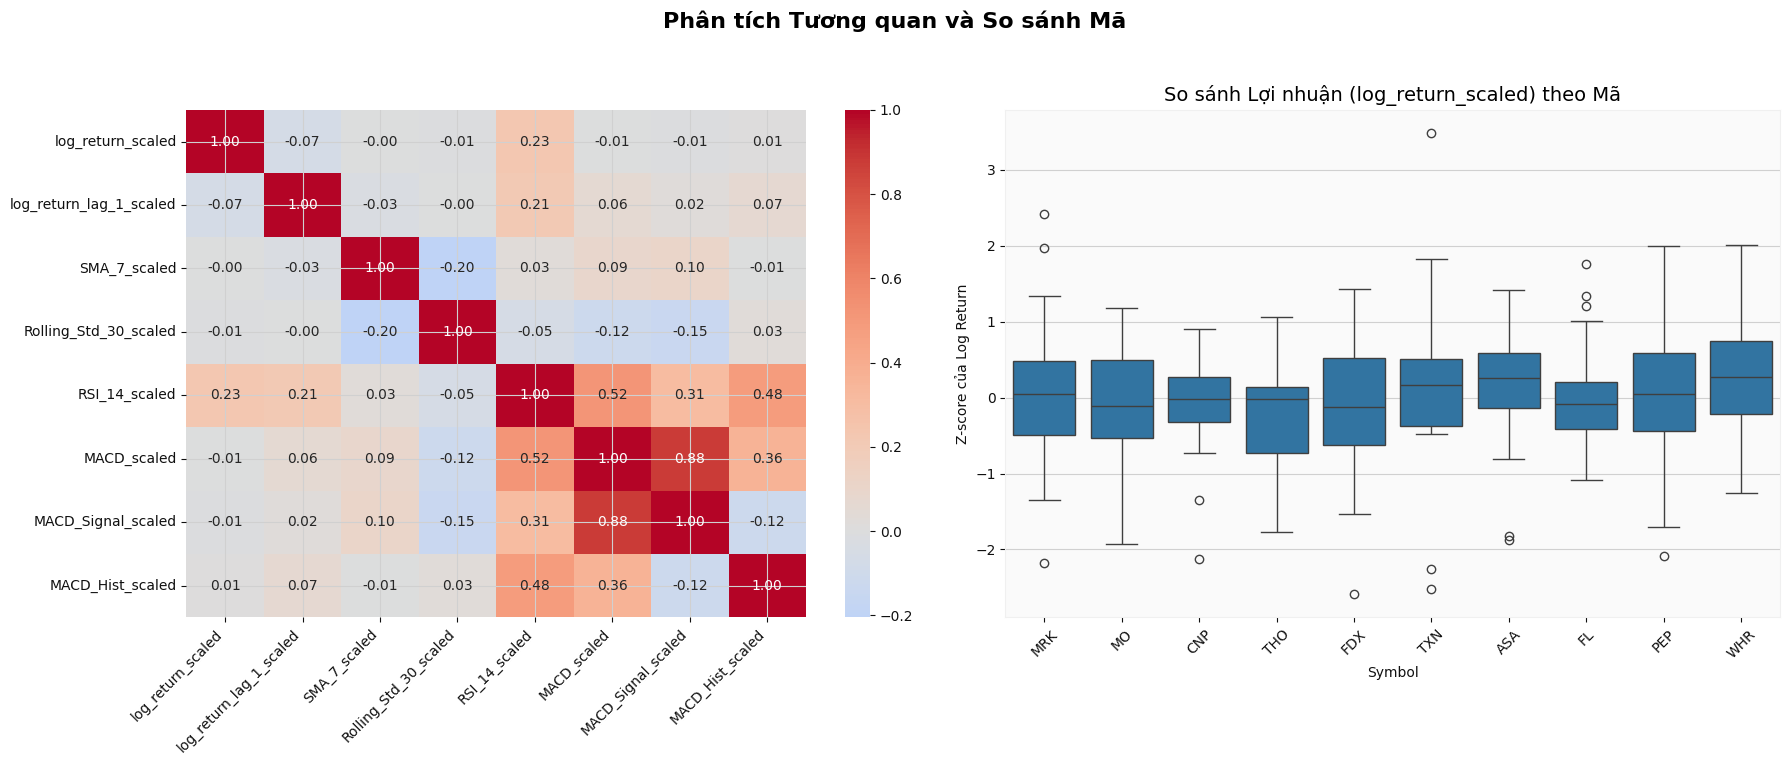

In [104]:
# Kiểm tra xem sample_pd có tồn tại và có dữ liệu không
if 'sample_pd' in locals() and not sample_pd.empty:
    
    # Tạo một Figure mới (fig2) cho 2 biểu đồ này
    fig3, axes3 = plt.subplots(1, 2, figsize=(18, 8))
    fig3.suptitle("Phân tích Tương quan và So sánh Mã", fontsize=16)

    # 1. HEATMAP TƯƠNG QUAN ĐẶC TRƯNG
    corr_matrix = sample_pd[features_cols_scaled].corr()
    
    sns.heatmap(
        corr_matrix, 
        annot=True,     
        cmap='coolwarm',  
        center=0,       
        fmt='.2f',      
        ax=axes3[0]     
    )
    axes3[0].tick_params(axis='x', rotation=45)
    for label in axes3[0].get_xticklabels():
        label.set_horizontalalignment('right')

    axes3[0].tick_params(axis='y', rotation=0)

    # 2. BOXPLOT SO SÁNH LỢI NHUẬN (LOG_RETURN)
    # Lấy Top 10 mã có nhiều dữ liệu nhất trong mẫu để vẽ
    top_symbols = sample_pd['Symbol'].value_counts().head(10).index
    sample_top_symbols = sample_pd[sample_pd['Symbol'].isin(top_symbols)]
    sns.boxplot(
        data=sample_top_symbols, 
        x='Symbol', 
        y='log_return_scaled', 
        ax=axes3[1] 
    )
    axes3[1].set_title("So sánh Lợi nhuận (log_return_scaled) theo Mã", fontsize=14)
    axes3[1].set_ylabel("Z-score của Log Return")
    axes3[1].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print("Không thể vẽ Heatmap/Boxplot vì 'sample_pd' rỗng hoặc không tồn tại.")


#### TẠO NHÃN (LABEL) CHO MÔ HÌNH DỰ ĐOÁN

In [107]:
output_path = "C:/Users/H13P/Desktop/BigData/stock_market_log_scaled"
df_scaled = spark.read.parquet(output_path)
print("Đã đọc lại dữ liệu đã chuẩn hoá từ Parquet.")

Đã đọc lại dữ liệu đã chuẩn hoá từ Parquet.


In [108]:
# Định nghĩa lại Window
w = Window.partitionBy("Symbol").orderBy("Date")

# Dùng F.lead() để "nhìn về phía trước 1 ngày"
df_with_label = df_scaled.withColumn(
    "label",
    F.lead("log_return").over(w) # Lấy log_return của hàng tiếp theo
)

df_model_ready = df_with_label.dropna(subset=["label"])

print(f"Đã tạo 'label' (log_return T+1). Số dòng sẵn sàng cho mô hình: {df_model_ready.count():,}")

df_model_ready.select("Date", "Symbol", "log_return", "label").show(10)

Đã tạo 'label' (log_return T+1). Số dòng sẵn sàng cho mô hình: 16,192,098
+----------+------+--------------------+--------------------+
|      Date|Symbol|          log_return|               label|
+----------+------+--------------------+--------------------+
|2011-01-19|   AAT|-0.00563140714772...|-0.00188418361901...|
|2011-01-20|   AAT|-0.00188418361901...|0.001884183619018962|
|2011-01-21|   AAT|0.001884183619018962|0.002349846837299...|
|2011-01-24|   AAT|0.002349846837299...|-0.00140911680752...|
|2011-01-25|   AAT|-0.00140911680752...|                 0.0|
|2011-01-26|   AAT|                 0.0|0.006093076516940...|
|2011-01-27|   AAT|0.006093076516940...|-0.00468395970941...|
|2011-01-28|   AAT|-0.00468395970941...| -4.6927091906797E-4|
|2011-01-31|   AAT| -4.6927091906797E-4| 4.69270919067966E-4|
|2011-02-01|   AAT| 4.69270919067966E-4|-0.00895978868558...|
+----------+------+--------------------+--------------------+
only showing top 10 rows



### MÔ HÌNH 1: PHÂN TÍCH RỦI RO (K-MEANS CLUSTERING)
Mục tiêu: Phân nhóm các cổ phiếu dựa trên BẢN CHẤT của chúng (Rủi ro & Xu hướng), không phải giá trị hàng ngày.


In [109]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

#### 1. Chọn đặc trưng để phân cụm

In [110]:
features_for_cluster = [
    "Rolling_Std_30_scaled", # Đại diện cho Rủi ro
    "SMA_7_scaled"           # Đại diện cho Xu hướng
]
print(f"Sử dụng các đặc trưng: {features_for_cluster}")

# Vector Assembler
# Spark ML yêu cầu các đặc trưng phải nằm trong 1 vector
assembler_kmeans = VectorAssembler(
    inputCols=features_for_cluster,
    outputCol="features_cluster" # Tên của vector
)

Sử dụng các đặc trưng: ['Rolling_Std_30_scaled', 'SMA_7_scaled']


#### 3. Định nghĩa mô hình K-Means

In [111]:
# phân thành 4 cụm (k=4)
kmeans = KMeans(
    featuresCol="features_cluster", # Dùng vector ở trên
    predictionCol="cluster_id",     # Tên cột kết quả
    k=4,                            # Số cụm
    seed=42                         # Để kết quả nhất quán
)

# Tạo Pipeline
pipeline_kmeans = Pipeline(stages=[assembler_kmeans, kmeans])

#### 4. Huấn luyện mô hình

In [112]:
model_kmeans = pipeline_kmeans.fit(df_model_ready)
print("Huấn luyện K-Means thành công!")

Huấn luyện K-Means thành công!


#### 5. Lấy kết quả

In [113]:
print("\n--- KẾT QUẢ TÂM CỤM (CLUSTER CENTERS) ---")
# Lấy các tâm cụm (đã chuẩn hoá Z-score)
centers = model_kmeans.stages[-1].clusterCenters()

print(f"Cột đặc trưng: {features_for_cluster}")
for i, center in enumerate(centers):
    print(f"Cụm {i}: {center}")


--- KẾT QUẢ TÂM CỤM (CLUSTER CENTERS) ---
Cột đặc trưng: ['Rolling_Std_30_scaled', 'SMA_7_scaled']
Cụm 0: [-0.28179227  1.6597669 ]
Cụm 1: [ 2.50146864 -0.53968111]
Cụm 2: [ 0.10055598 -0.72677221]
Cụm 3: [-0.56493729  0.06297294]


In [115]:
# Cụm 0: Cổ phiếu ổn định với biến động thấp và xu hướng tăng trưởng.
# Cụm 1: Cổ phiếu biến động mạnh và có xu hướng giảm giá.
# Cụm 2: Cổ phiếu ổn định nhưng đang điều chỉnh giảm nhẹ.
# Cụm 3: Cổ phiếu ít biến động, không thay đổi mạnh trong ngắn hạn. 

Cụm 0: [-0.28179227, 1.6597669]

Đây là mức độ biến động trong giá cổ phiếu trong 30 ngày qua. Giá trị âm có nghĩa là cổ phiếu này có độ biến động thấp hơn so với mức trung bình của toàn bộ dữ liệu. Điều này có thể chỉ ra rằng cổ phiếu này khá ổn định.

SMA 7 ngày có giá trị cao hơn mức trung bình, điều này có thể chỉ ra rằng cổ phiếu này đang có xu hướng tăng trưởng mạnh trong thời gian gần đây (so với 7 ngày trước).

Phân tích: Cụm này có thể đại diện cho những cổ phiếu ổn định nhưng đang có xu hướng tăng giá mạnh. Đây có thể là các cổ phiếu "tăng trưởng" trong ngắn hạn.

Cụm 1: [2.50146864, -0.53968111]

Rolling_Std_30_scaled: 2.50

Đây là một giá trị rất cao cho độ biến động trong 30 ngày qua. Cổ phiếu trong cụm này có sự biến động mạnh hơn rất nhiều so với các cổ phiếu khác trong dataset.

SMA_7_scaled: -0.54

Giá trị này cho thấy cổ phiếu trong cụm này đang có xu hướng giảm trong 7 ngày gần nhất.

Phân tích: Cụm này có thể đại diện cho các cổ phiếu có biến động mạnh nhưng lại đang trong giai đoạn giảm giá. Các cổ phiếu này có thể đang gặp khó khăn hoặc có sự giảm sút mạnh trong thời gian ngắn, nhưng vì biến động mạnh nên cũng có thể tiềm ẩn cơ hội đầu tư.

Cụm 2: [0.10055598, -0.72677221]

Rolling_Std_30_scaled: 0.10

Độ biến động của cổ phiếu này gần với mức trung bình (vì giá trị gần 0). Điều này cho thấy cổ phiếu này ổn định nhưng không có sự biến động lớn.

SMA_7_scaled: -0.73

Cổ phiếu này đang có xu hướng giảm trong 7 ngày gần nhất, có thể là dấu hiệu của một xu hướng giảm giá nhẹ.

Phân tích: Cụm này có thể đại diện cho các cổ phiếu ổn định, nhưng đang có xu hướng giảm giá trong thời gian ngắn. Đây có thể là những cổ phiếu ổn định nhưng đang trải qua một giai đoạn điều chỉnh.

Cụm 3: [-0.56493729, 0.06297294]

Rolling_Std_30_scaled: -0.56

Độ biến động thấp hơn mức trung bình, cho thấy cổ phiếu này tương đối ổn định và ít biến động.

SMA_7_scaled: 0.06

SMA 7 ngày gần với 0, cho thấy cổ phiếu này không có nhiều thay đổi trong xu hướng giá trong khoảng thời gian ngắn (có thể là không tăng không giảm, hoặc đang dao động nhẹ).

#### 6. Lưu lại DataFrame đã được gán nhãn cụm

In [116]:
df_clustered = model_kmeans.transform(df_model_ready)
df_clustered.cache()
df_model_ready.unpersist()

print("\nXem thử 10 dòng đã được gán Cụm (cluster_id):")
df_clustered.select("Date", "Symbol", "cluster_id", *features_for_cluster).show(10)

model_kmeans.write().overwrite().save("models/kmeans_model")
print("Mô hình K-Means đã được lưu/cập nhật tại 'models/kmeans_model'")


Xem thử 10 dòng đã được gán Cụm (cluster_id):
+----------+------+----------+---------------------+-------------------+
|      Date|Symbol|cluster_id|Rolling_Std_30_scaled|       SMA_7_scaled|
+----------+------+----------+---------------------+-------------------+
|1992-02-13|  ACFN|         1|   1.9433408603075502|0.45034833078588793|
|1992-02-14|  ACFN|         2|    0.750434681770073| 0.4369427239468391|
|1992-02-18|  ACFN|         3|  0.21287722880274748|0.43526698334918934|
|1992-02-19|  ACFN|         3| -0.11111418182463545| 0.4382832528365289|
|1992-02-20|  ACFN|         2|   0.9582495654475429| 0.4838624803594056|
|1992-02-21|  ACFN|         2|   0.8568507900104608| 0.5422728326202402|
|1992-02-24|  ACFN|         1|   1.2589044408003833| 0.5709992238302447|
|1992-02-25|  ACFN|         2|   1.0345358911724543| 0.6255793989234683|
|1992-02-26|  ACFN|         0|   1.0199302360852815|  0.662923725664597|
|1992-02-27|  ACFN|         0|    0.891513072763099| 0.7117586179737889|
+---

### Trực quan hoá & diễn giải mô hình 1

#### 1. Chuẩn bị dữ liệu 

In [117]:
# df_clustered là DataFrame đã có cột 'cluster_id' từ bước 9
features_for_cluster = [
    "Rolling_Std_30_scaled", # Trục X (Rủi ro)
    "SMA_7_scaled"           # Trục Y (Xu hướng)
]

#### 2. VẼ BIỂU ĐỒ SCATTER PLOT

Đang lấy mẫu 100,000 điểm (fraction=0.0062) để vẽ...


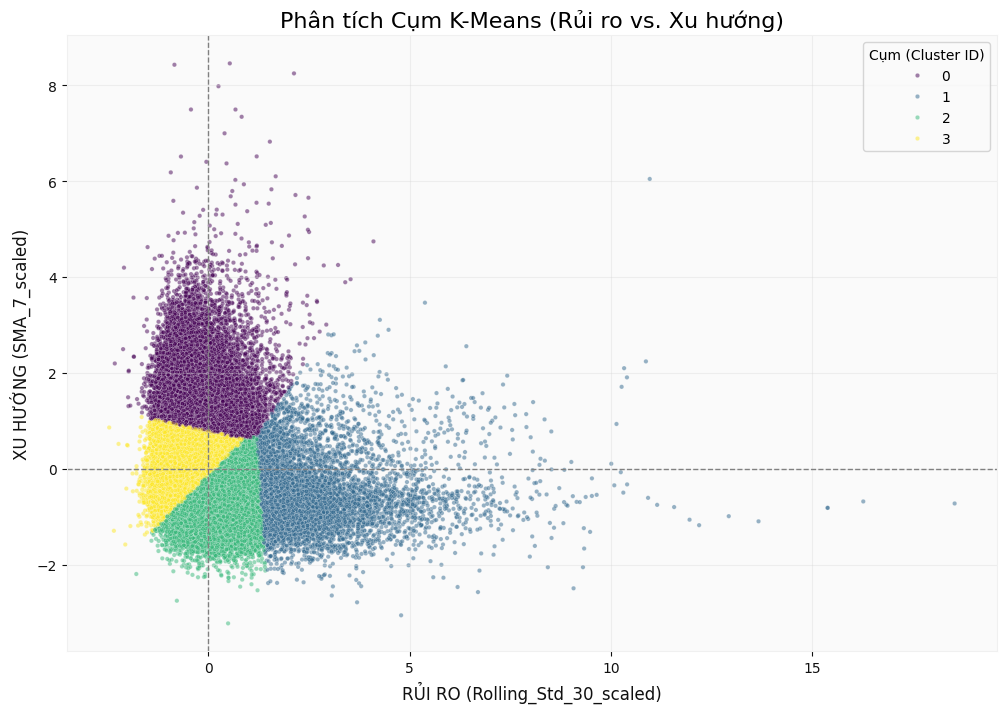

In [119]:
# 2. LẤY MẪU (SAMPLING) 
total_rows = df_clustered.count()
# Lấy tối đa 50,000 điểm
sample_size = min(100000, total_rows) 
fraction = sample_size / total_rows if total_rows > 0 else 0

if fraction > 0:
    print(f"Đang lấy mẫu {sample_size:,} điểm (fraction={fraction:.4f}) để vẽ...")
    sample_pd = df_clustered.select("cluster_id", *features_for_cluster) \
                            .sample(False, fraction, seed=42) \
                            .toPandas()

    # 3. VẼ BIỂU ĐỒ SCATTER PLOT
    plt.figure(figsize=(12, 8))
    
    # Dùng seaborn để vẽ scatter plot với màu (hue) là cluster_id
    sns.scatterplot(
        data=sample_pd,
        x="Rolling_Std_30_scaled", # Trục Rủi ro
        y="SMA_7_scaled",          # Trục Xu hướng
        hue="cluster_id",          # Tô màu theo cụm
        palette="viridis",         # Bảng màu 
        s=10,                      # Kích thước điểm nhỏ
        alpha=0.5                  # Làm mờ để thấy mật độ
    )
    
    # 4. Tinh chỉnh biểu đồ
    plt.title("Phân tích Cụm K-Means (Rủi ro vs. Xu hướng)", fontsize=16)
    plt.xlabel("RỦI RO (Rolling_Std_30_scaled)", fontsize=12)
    plt.ylabel("XU HƯỚNG (SMA_7_scaled)", fontsize=12)
    
    # Vẽ 2 đường 0 để chia 4 góc phần tư
    plt.axhline(0, color='grey', linestyle='--', linewidth=1)
    plt.axvline(0, color='grey', linestyle='--', linewidth=1)
    
    plt.legend(title='Cụm (Cluster ID)')
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("Không có dữ liệu để vẽ biểu đồ K-Means.")

#### 3. Vẽ biểu đồ Heatmap tương quan

Đang chuẩn bị phân tích Cụm 0...
--- 15 mã hàng đầu trong Cụm 0: ['WRE', 'HMC', 'GE', 'XOM', 'PBI', 'NFG', 'GIM', 'IBM', 'OXY', 'HAL', 'PHI', 'F', 'NX', 'MRO', 'BK'] ---


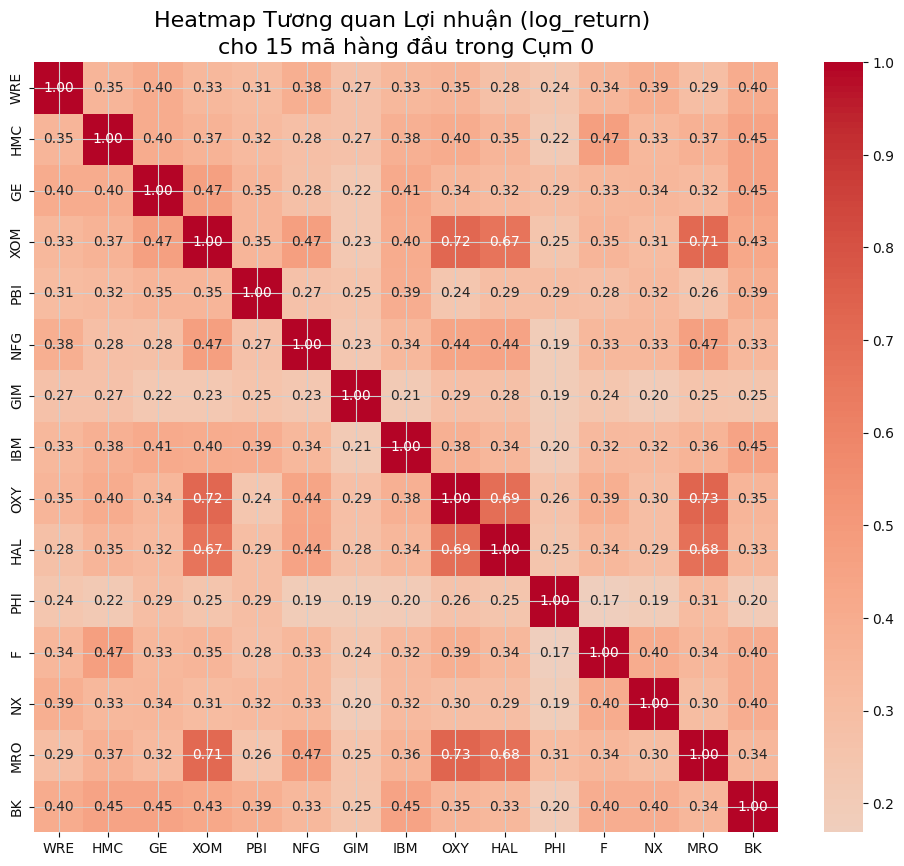

In [120]:
CLUSTER_TO_ANALYZE = 0 
print(f"Đang chuẩn bị phân tích Cụm {CLUSTER_TO_ANALYZE}...")

# 1. Lọc DataFrame để chỉ lấy các dòng thuộc Cụm này
df_one_cluster = df_clustered.filter(F.col("cluster_id") == CLUSTER_TO_ANALYZE)

# 2. Tìm 15 mã xuất hiện thường xuyên nhất TRONG CỤM NÀY
try:
    top_15_symbols_in_cluster = df_one_cluster.groupBy("Symbol").count() \
                                    .orderBy(F.col("count").desc()) \
                                    .limit(15) \
                                    .select("Symbol") \
                                    .rdd.flatMap(lambda x: x).collect()
    
    print(f"--- 15 mã hàng đầu trong Cụm {CLUSTER_TO_ANALYZE}: {top_15_symbols_in_cluster} ---")

    if top_15_symbols_in_cluster:
        # 3. Lọc dữ liệu chỉ lấy 15 mã này (vẫn chỉ trong cụm này)
        df_top_15 = df_one_cluster.filter(
            F.col("Symbol").isin(top_15_symbols_in_cluster)
        )

        # 4. Pivot bảng (dùng 'log_return' để tính tương quan)
        df_pivot_cluster = df_top_15.groupBy("Date") \
                                    .pivot("Symbol", top_15_symbols_in_cluster) \
                                    .agg(F.first("log_return"))

        # 5. Chuyển sang Pandas để tính tương quan
        pivot_pd_cluster = df_pivot_cluster.toPandas().set_index("Date")

        # 6. Làm sạch
        pivot_pd_cluster = pivot_pd_cluster.replace(0, np.nan).dropna(how='all')

        # 7. Tính ma trận tương quan
        corr_matrix_cluster = pivot_pd_cluster.corr()

        # 8. Vẽ Heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            corr_matrix_cluster, 
            annot=True, 
            cmap='coolwarm', 
            center=0, 
            fmt='.2f'
        )
        plt.title(f"Heatmap Tương quan Lợi nhuận (log_return) \ncho 15 mã hàng đầu trong Cụm {CLUSTER_TO_ANALYZE}", fontsize=16)
        plt.show()

    else:
        print(f"Không tìm thấy đủ mã để vẽ heatmap cho Cụm {CLUSTER_TO_ANALYZE}.")

except Exception as e:
    print(f"Lỗi khi vẽ heatmap K-Means: {e}")

### Mô hình 2: Dự đoán lợi nhuận (Linear Regression)

In [121]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

#### 1. Định nghĩa các đặc trưng dự đoán (ngày T)

In [122]:
features_predict_cols = [
    "cluster_id",              
    "log_return_scaled", 
    "log_return_lag_1_scaled", 
    "SMA_7_scaled", 
    "Rolling_Std_30_scaled",
    "RSI_14_scaled",
    "MACD_scaled",
    "MACD_Signal_scaled",
    "MACD_Hist_scaled"
]
print(f"Sử dụng {len(features_predict_cols)} đặc trưng (bao gồm cluster_id) để dự đoán 'label'.")

assembler_predict = VectorAssembler(
    inputCols=features_predict_cols,
    outputCol="features"
)

Sử dụng 9 đặc trưng (bao gồm cluster_id) để dự đoán 'label'.


#### 2. Chia Train/Test theo THỜI GIAN

In [123]:
split_date = "2020-01-01" 
print(f"Chia dữ liệu Train/Test tại mốc: {split_date}")

train_data = df_clustered.filter(F.col("Date") < split_date)
test_data = df_clustered.filter(F.col("Date") >= split_date)

train_data.cache()
test_data.cache()
print(f"Tập Train: {train_data.count():,} dòng (Trước {split_date})")
print(f"Tập Test: {test_data.count():,} dòng (Từ {split_date} trở đi)")

Chia dữ liệu Train/Test tại mốc: 2020-01-01
Tập Train: 14,110,679 dòng (Trước 2020-01-01)
Tập Test: 2,081,419 dòng (Từ 2020-01-01 trở đi)


#### 3. Định nghĩa mô hình

In [124]:
lr = LinearRegression(
    featuresCol="features",
    labelCol="label",      
    predictionCol="prediction"
)

#### 4. Huấn luyện mô hình

In [125]:
pipeline_lr = Pipeline(stages=[assembler_predict, lr])
model_lr = pipeline_lr.fit(train_data)
print("Huấn luyện Linear Regression thành công!")

Huấn luyện Linear Regression thành công!


#### 5. Đánh giá mô hình trên tập test

In [126]:
predictions_lr = model_lr.transform(test_data)
# Tính toán RMSE
evaluator_rmse = RegressionEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="rmse"
)
rmse_lr = evaluator_rmse.evaluate(predictions_lr)

# Tính toán R2
evaluator_r2 = RegressionEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="r2"
)
r2_lr = evaluator_r2.evaluate(predictions_lr)

#### 6. Lấy kết quả 

In [134]:
print(f"Root Mean Squared Error (RMSE) trên tập Test = {rmse_lr:.6f}")
print(f"R-squared (R2) trên tập Test = {r2_lr:.6f}")

print("\n--- Diễn giải ---")
print(f"RMSE = {rmse_lr:.6f}: Mô hình dự đoán sai số {rmse_lr*100:.4f}% log_return.")
print(f"R2 = {r2_lr:.6f}: Mô hình giải thích được {r2_lr*100:.4f}% sự biến động của lợi nhuận ngày mai.")
print("\nXem thử 10 dự đoán (so sánh 'label' và 'prediction'):")
predictions_lr.select("Date", "Symbol", "label", "prediction").show(10)

Root Mean Squared Error (RMSE) trên tập Test = 0.040550
R-squared (R2) trên tập Test = 0.000945

--- Diễn giải ---
RMSE = 0.040550: Mô hình dự đoán sai số 4.0550% log_return.
R2 = 0.000945: Mô hình giải thích được 0.0945% sự biến động của lợi nhuận ngày mai.

Xem thử 10 dự đoán (so sánh 'label' và 'prediction'):
+----------+------+--------------------+--------------------+
|      Date|Symbol|               label|          prediction|
+----------+------+--------------------+--------------------+
|2020-01-02|   AAT|0.019811362440213674|0.001772399799894...|
|2020-01-03|   AAT|0.007383204665123742|-0.00292394497938...|
|2020-01-06|   AAT|-0.01922306735487...|-0.00275584402556...|
|2020-01-07|   AAT|0.003083056016949...|0.001449029461951017|
|2020-01-08|   AAT|-0.00176048890516...|-7.90454749720694...|
|2020-01-09|   AAT|0.003518069906752...|-9.68742785698201...|
|2020-01-10|   AAT|0.011566032800274125|-0.00156427917510...|
|2020-01-13|   AAT|-0.00718596435543...|-0.00297421585234...|
|202

#### 7. Dọn dẹp và lưu mô hình

In [128]:
df_scaled.unpersist()
df_clustered.unpersist()
train_data.unpersist()
test_data.unpersist()
model_lr.write().overwrite().save("models/linear_regression_model")

print("Mô hình Linear Regression đã được lưu/cập nhật tại 'models/linear_regression_model'")

Mô hình Linear Regression đã được lưu/cập nhật tại 'models/linear_regression_model'


### Mô hình RandomForest

In [129]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

#### 1. Định nghĩa mô hình

In [130]:
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="label",      
    predictionCol="prediction",
    seed=42,                # Để kết quả nhất quán
    numTrees=100            # Bắt đầu với 100 cây (có thể tăng/giảm)
)

#### 2. Tạo pipeline

In [131]:
pipeline_rf = Pipeline(stages=[assembler_predict, rf])

#### 3. Huấn luyện mô hình 

In [132]:
model_rf = pipeline_rf.fit(train_data)
print("Huấn luyện RandomForest thành công!")

Huấn luyện RandomForest thành công!


#### 4. Đánh giá mô hình

In [133]:
predictions_rf = model_rf.transform(test_data)
print("\n---  KẾT QUẢ ĐÁNH GIÁ (MÔ HÌNH 2 - RANDOM FOREST)  ---")

evaluator_rmse = RegressionEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="rmse"
)
rmse_rf = evaluator_rmse.evaluate(predictions_rf)

evaluator_r2 = RegressionEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="r2"
)
r2_rf = evaluator_r2.evaluate(predictions_rf)

print(f"📈 Root Mean Squared Error (RMSE) trên tập Test = {rmse_rf:.6f}")
print(f"📈 R-squared (R2) trên tập Test = {r2_rf:.6f}")

print("\n--- Diễn giải ---")
print(f"RMSE = {rmse_rf:.6f}: Nghĩa là trung bình, mô hình dự đoán sai số {rmse_rf*100:.4f}% log_return.")
print(f"R2 = {r2_rf:.6f}: Mô hình (RandomForest) giải thích được {r2_rf*100:.4f}% sự biến động của lợi nhuận ngày mai.")

print("\nXem thử 10 dự đoán (so sánh 'label' và 'prediction'):")
predictions_rf.select("Date", "Symbol", "label", "prediction").show(10)



---  KẾT QUẢ ĐÁNH GIÁ (MÔ HÌNH 2 - RANDOM FOREST)  ---
📈 Root Mean Squared Error (RMSE) trên tập Test = 0.040546
📈 R-squared (R2) trên tập Test = 0.001177

--- Diễn giải ---
RMSE = 0.040546: Nghĩa là trung bình, mô hình dự đoán sai số 4.0546% log_return.
R2 = 0.001177: Mô hình (RandomForest) giải thích được 0.1177% sự biến động của lợi nhuận ngày mai.

Xem thử 10 dự đoán (so sánh 'label' và 'prediction'):
+----------+------+--------------------+--------------------+
|      Date|Symbol|               label|          prediction|
+----------+------+--------------------+--------------------+
|2020-01-02|   AAT|0.019811362440213674|9.391742151069334E-5|
|2020-01-03|   AAT|0.007383204665123742|-0.00104675005149...|
|2020-01-06|   AAT|-0.01922306735487...|-4.62614090518769...|
|2020-01-07|   AAT|0.003083056016949...|-1.66208532178587...|
|2020-01-08|   AAT|-0.00176048890516...|-3.32640962134852E-4|
|2020-01-09|   AAT|0.003518069906752...|-3.88476397736486...|
|2020-01-10|   AAT|0.01156603280

#### 5. Dọn dẹp và lưu mô hình

In [135]:
df_scaled.unpersist()
df_clustered.unpersist()
train_data.unpersist()
test_data.unpersist()
model_rf.write().overwrite().save("models/random_forest_model")
print("Mô hình Random Forest đã được lưu/cập nhật tại 'models/random_forest_model'")

Mô hình Random Forest đã được lưu/cập nhật tại 'models/random_forest_model'


C:\Users\H13P\anaconda3\envs\pyspark310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


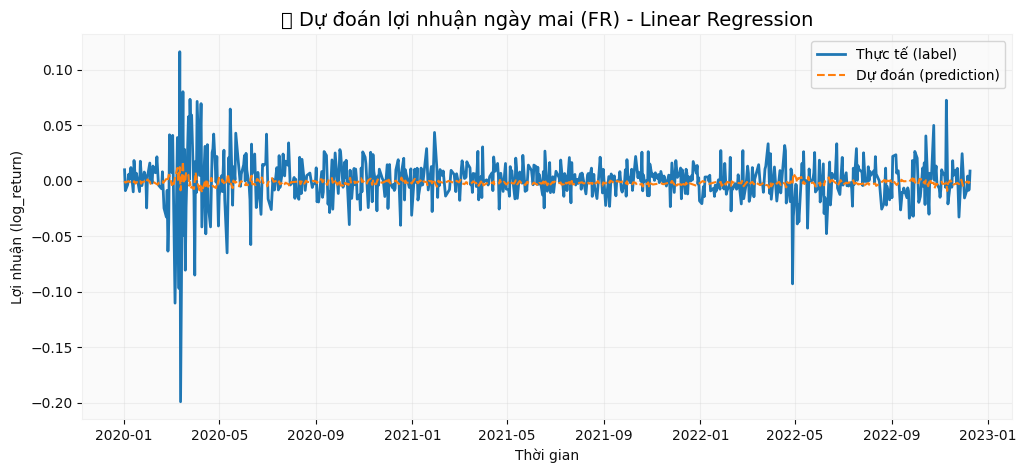

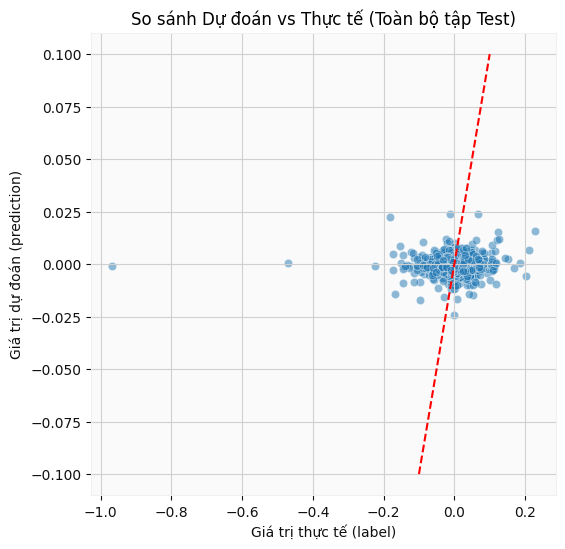

C:\Users\H13P\AppData\Local\Temp\ipykernel_19600\1450383432.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coeffs, x="Coefficient", y="Feature", palette="coolwarm")


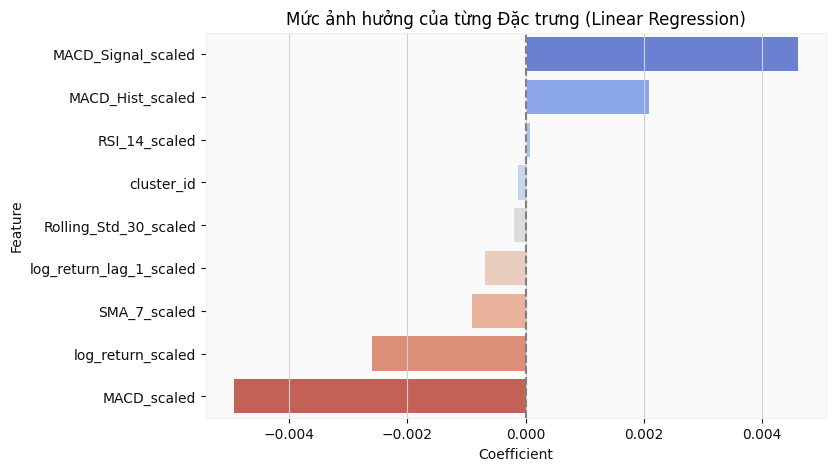

In [136]:
# ===========================================================
# 🎨 TRỰC QUAN HÓA MÔ HÌNH 2: LINEAR REGRESSION
# ===========================================================

# Lấy dữ liệu dự đoán ra Pandas để trực quan
preds_pd = predictions_lr.select("Date", "Symbol", "label", "prediction").toPandas()
preds_pd["Date"] = pd.to_datetime(preds_pd["Date"])

# Chọn 1 mã cổ phiếu đại diện (ví dụ: cổ phiếu có nhiều dòng dữ liệu nhất)
top_symbol = preds_pd["Symbol"].value_counts().index[0]
stock_pd = preds_pd[preds_pd["Symbol"] == top_symbol].sort_values("Date")

# -----------------------------------------------------------
# 1️⃣ Biểu đồ đường: Dự đoán vs Thực tế theo thời gian
# -----------------------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(stock_pd["Date"], stock_pd["label"], label="Thực tế (label)", linewidth=2)
plt.plot(stock_pd["Date"], stock_pd["prediction"], label="Dự đoán (prediction)", linestyle='--')
plt.title(f"📈 Dự đoán lợi nhuận ngày mai ({top_symbol}) - Linear Regression", fontsize=14)
plt.xlabel("Thời gian")
plt.ylabel("Lợi nhuận (log_return)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# -----------------------------------------------------------
# 2️⃣ Biểu đồ phân tán: label vs prediction
# -----------------------------------------------------------
plt.figure(figsize=(6,6))
sns.scatterplot(data=preds_pd.sample(2000, random_state=42), 
                x="label", y="prediction", alpha=0.5)
plt.plot([-0.1,0.1], [-0.1,0.1], color='red', linestyle='--')  # đường y=x
plt.title("So sánh Dự đoán vs Thực tế (Toàn bộ tập Test)")
plt.xlabel("Giá trị thực tế (label)")
plt.ylabel("Giá trị dự đoán (prediction)")
plt.show()

# -----------------------------------------------------------
# 3️⃣ Biểu đồ hệ số tuyến tính (Coefficient plot)
# -----------------------------------------------------------
# Lấy hệ số từ mô hình LR
coeffs = pd.DataFrame({
    "Feature": features_predict_cols,
    "Coefficient": model_lr.stages[-1].coefficients
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=coeffs, x="Coefficient", y="Feature", palette="coolwarm")
plt.title("Mức ảnh hưởng của từng Đặc trưng (Linear Regression)")
plt.axvline(0, color='gray', linestyle='--')
plt.show()


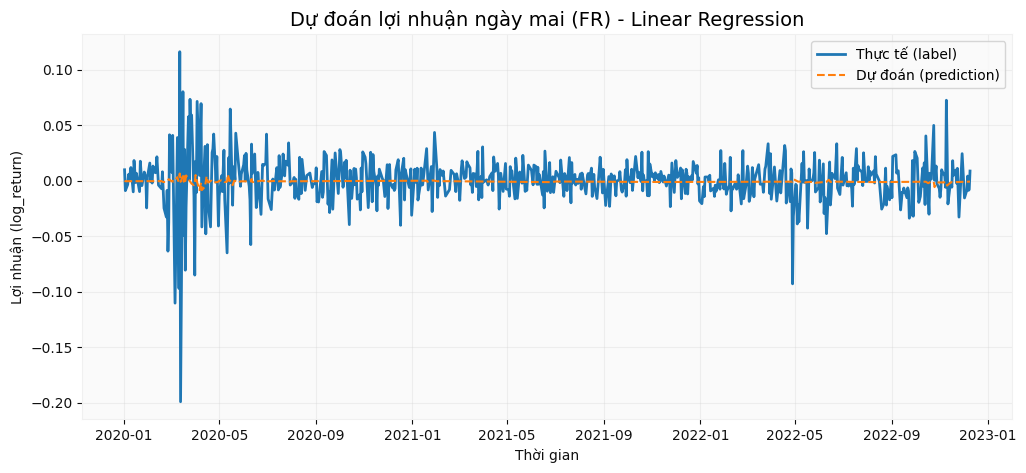

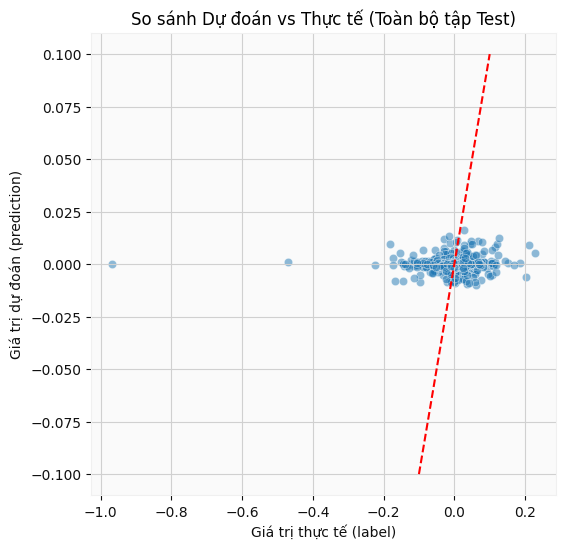

TypeError: '<' not supported between instances of 'SparseVector' and 'SparseVector'

In [139]:
# ===========================================================
# 🎨 TRỰC QUAN HÓA MÔ HÌNH 2: LINEAR REGRESSION
# ===========================================================

# Lấy dữ liệu dự đoán ra Pandas để trực quan
preds_pd = predictions_rf.select("Date", "Symbol", "label", "prediction").toPandas()
preds_pd["Date"] = pd.to_datetime(preds_pd["Date"])

# Chọn 1 mã cổ phiếu đại diện (ví dụ: cổ phiếu có nhiều dòng dữ liệu nhất)
top_symbol = preds_pd["Symbol"].value_counts().index[0]
stock_pd = preds_pd[preds_pd["Symbol"] == top_symbol].sort_values("Date")

# -----------------------------------------------------------
# 1️⃣ Biểu đồ đường: Dự đoán vs Thực tế theo thời gian
# -----------------------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(stock_pd["Date"], stock_pd["label"], label="Thực tế (label)", linewidth=2)
plt.plot(stock_pd["Date"], stock_pd["prediction"], label="Dự đoán (prediction)", linestyle='--')
plt.title(f"Dự đoán lợi nhuận ngày mai ({top_symbol}) - Linear Regression", fontsize=14)
plt.xlabel("Thời gian")
plt.ylabel("Lợi nhuận (log_return)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# -----------------------------------------------------------
# 2️⃣ Biểu đồ phân tán: label vs prediction
# -----------------------------------------------------------
plt.figure(figsize=(6,6))
sns.scatterplot(data=preds_pd.sample(2000, random_state=42), 
                x="label", y="prediction", alpha=0.5)
plt.plot([-0.1,0.1], [-0.1,0.1], color='red', linestyle='--')  # đường y=x
plt.title("So sánh Dự đoán vs Thực tế (Toàn bộ tập Test)")
plt.xlabel("Giá trị thực tế (label)")
plt.ylabel("Giá trị dự đoán (prediction)")
plt.show()

# -----------------------------------------------------------
# 3️⃣ Biểu đồ hệ số tuyến tính (Coefficient plot)
# -----------------------------------------------------------
coeffs = pd.DataFrame({
    "Feature": features_predict_cols,
    "Coefficient": model_rf.stages[-1].featureImportances
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=coeffs, x="Coefficient", y="Feature", palette="coolwarm")
plt.title("Mức ảnh hưởng của từng Đặc trưng (Linear Regression)")
plt.axvline(0, color='gray', linestyle='--')
plt.show()
